## Crawl in the directory, load data in

In [1]:
## The InLight col we have in the count csv files and count tab in the tdms file is based on cX data. Meaning that we're doing
## head tracking but not using in the PI calculation.
## Here, I wrote a function to generate InLight column for a given HeadX coordinates and respective borders.
## I send only the headX while light ON (pattern01 or pattern10) to this function and return a binary list.
def InLightDetection(data,minimumBorder,maximumBorder):
    InLightBasedOnHeadXcoords = []
    
    for i in range(len(data)):
        if minimumBorder <= data[i] <= maximumBorder:
            InLightBasedOnHeadXcoords.append(1)
            
        else:
            InLightBasedOnHeadXcoords.append(0)
    return InLightBasedOnHeadXcoords

## Since the FPS from different cameras can be different, here I detect the FPS automatically rather than relying on user input.
def detectFPS(timeStamps):
    Second_prev = 0
    counter = 0 
    fpsDict= {}

    for i in range(len(timeStamps)):
        Second_next = timeStamps[i].second

        if Second_next == Second_prev:
            counter += 1 

        else:
            fpsDict[Second_prev] = counter
            counter = 0

        Second_prev = Second_next

    fps = Counter(fpsDict.values()).most_common()[0][0]
    
    return fps

def dataToDataframe(rootDir):
        
    ## Generate a single dataframe from the .tdms and pattern files 
    temp = {'Tdms file name':[],'Date':[],'Time':[],'mmPerPix':[],'fps':[],'Light Intensity(uW/mm2)':[],'Wind status':[],
            'Satiety':[],'Genotype':[],'Sex':[],'Status':[],'Fly ID':[],'cX(pix)':[],'HeadX(pix)':[],'HeadX(pix)_smoothed':[],
            'HeadY(pix)':[], 'InLight':[],'InLight_HeadX|P01':[],'InLight_HeadX|P10':[],'First light contact index_of_the_whole_data|P01':[],'First light contact index_of_the_whole_data|P10':[],
            'LightON index|P01':[],'First light contact index in P01':[],'First light contact index in P10':[],'LightON index|P10':[],'Border|P01':[],'Border|P10':[]}
    
    # Removed 'Light type':[], since all constant
    
    slidingWindowSizeinframes = 25
    numOfTdmsFiles = 0
    ## get access to the files in each ORN folder
    fileList = os.listdir(rootDir)
    bar = progressbar.ProgressBar()       
    ## Loop thru the file list to find tdms files and their related csv pattern files
    for fname in bar(fileList):
        if fname[-5:] == '.tdms':    
            numOfTdmsFiles += 1
            ## Open the tdms file
            f = TdmsFile(os.path.join(rootDir,fname))
            
            ## Load the tdms into a pandas df
            TDMSdf = f.as_dataframe()

            try:
            ## Open the pattern csv files to extract light border info per fly
                tdmsNameNoExtension = fname[:-5]
                P01_fname = tdmsNameNoExtension + '_Pattern01.csv'
                P10_fname = tdmsNameNoExtension + '_Pattern10.csv'
                
                P01_df = pd.read_csv(os.path.join(rootDir,P01_fname))
                P10_df = pd.read_csv(os.path.join(rootDir,P10_fname))
                
            except:
                print 'No pattern file(s) for %s' %(tdmsNameNoExtension)
                
            ## Get exp info from the tdms filename
            tdmsNameNoExtension = tdmsNameNoExtension.split('_')
            date = tdmsNameNoExtension[1]
            time = tdmsNameNoExtension[2]
            genotype = tdmsNameNoExtension[3]
            sex = tdmsNameNoExtension[4]
            intensity = tdmsNameNoExtension[5]
#             lightType = 'Constant'
            windState = tdmsNameNoExtension[6]
            satiety = tdmsNameNoExtension[7]

            ## Get the mm per pixel coefficient
            metaData = f.object().properties
            mmPerPix = metaData['X_mm_per_pixel']

            ## Detect the fps of the data for the LXS metric

            timeStamps = pd.to_datetime(TDMSdf["/\'Count\'/\'Time'"])
            fps = detectFPS(timeStamps)

            ## Get status info 
            if ('w1118' in genotype) | ('W1118' in genotype):
                status = 'Parent'
            elif (('Gal4' in genotype) | ('GAL4' in genotype)) & ('UAS' in genotype):
                status = 'Offspring'
            else:
                status = 'Unknown'
                print 'Unknown parental status in file %s' % (fname)

            ## simply putting fly IDs as numbers does not work due to missing chambers (i.e 3,4,6,7)
            ## thus, get a list of column names with fly IDs
            listOfFlyIDs = TDMSdf.columns[TDMSdf.columns.str.contains("/'Tracker'/'HeadX_pix")]

            for fly in listOfFlyIDs:

                ## get the fly ID from the data itself
                flyIndex = int(fly[-4:-1])

                ## format the fly index into 3 digits number,i.e '5' >> '005' 
                flyID = format(str(flyIndex).zfill(3))

                ## generate column names for the data need to be pulled from the df
                fly_cX_pix_ID = "/\'Count\'/\'Obj%s_cX'" % flyIndex 
                fly_inLight_ID = "/\'Count\'/\'Obj%s_InLight'" % flyIndex
                fly_headX_pix_ID = "/'Tracker'/'HeadX_pix" + str(flyID) + "'"
                fly_headY_pix_ID = "/'Tracker'/'HeadY_pix" + str(flyID) + "'"

                temp['Fly ID'].append(flyID)
                temp['cX(pix)'].append(TDMSdf[fly_cX_pix_ID].values.astype(float))
                temp['InLight'].append(TDMSdf[fly_inLight_ID].values.astype(float))
                temp['HeadX(pix)'].append(TDMSdf[fly_headX_pix_ID].values.astype(float))
                temp['HeadX(pix)_smoothed'].append(pd.rolling_mean(TDMSdf[fly_headX_pix_ID].values.astype(float),
                                                   window = slidingWindowSizeinframes, center=True, win_type="triang"))
                temp['HeadY(pix)'].append(TDMSdf[fly_headY_pix_ID].values.astype(float))

            ## Get the chunks where the light was ON   
            TDMSdf_pat01 = TDMSdf[TDMSdf["/\'Count\'/\'PatternState'"] == 'Pattern 01']    
            TDMSdf_pat10 = TDMSdf[TDMSdf["/\'Count\'/\'PatternState'"] == 'Pattern 10'] 

            LightOnP01 = min(TDMSdf_pat01.index),max(TDMSdf_pat01.index)
            LightOnP10 = min(TDMSdf_pat10.index),max(TDMSdf_pat10.index)

            for fly in listOfFlyIDs:
                ## get the fly ID from the data itself
                flyIndex = int(fly[-4:-1])

                ## format the fly index into 3 digits number,i.e '5' >> '005' 
                flyID = format(str(flyIndex).zfill(3))

                ## generate column names for the data need to be pulled from the df
                fly_headX_pix_ID = "/'Tracker'/'HeadX_pix" + str(flyID) + "'"
                border_P01 = P01_df.filter(regex='pix').iloc[1].values[flyIndex-1]
                border_P10 = P10_df.filter(regex='pix').iloc[1].values[flyIndex-1]

                ## get the headX coordinates of the fly where the light was ON - pattern01 or pattern10
                headXcoord_P01 = TDMSdf_pat01[fly_headX_pix_ID].values.astype(float)
                headXcoord_P10 = TDMSdf_pat10[fly_headX_pix_ID].values.astype(float)  

                ## send this data to the function along with the respective border info to get a binary list,
                ## indicating whether the fly was in the light or not.
                InLightBasedOnHeadX_P01 = InLightDetection(headXcoord_P01,border_P01,146)
                InLightBasedOnHeadX_P10 = InLightDetection(headXcoord_P10,0,border_P10)

                ## if the fly had ever been in the light, get the first time she did.
                if 1 in InLightBasedOnHeadX_P01:
                    P01_first_light_contact_index_of_the_whole_data = int(LightOnP01[0]) + int(InLightBasedOnHeadX_P01.index(1))
                    P01_first_light_contact_index_in_the_event = int(InLightBasedOnHeadX_P01.index(1))
                else:
                    P01_first_light_contact_index_of_the_whole_data = None
                    P01_first_light_contact_index_in_the_event = None

                if 1 in InLightBasedOnHeadX_P10:
                    P10_first_light_contact_index_of_the_whole_data = int(LightOnP10[0]) + int(InLightBasedOnHeadX_P10.index(1))
                    P10_first_light_contact_index_in_the_event = int(InLightBasedOnHeadX_P10.index(1))
                else:
                    P10_first_light_contact_index_of_the_whole_data = None
                    P10_first_light_contact_index_in_the_event = None

                ## append the info to temp dict
                temp['First light contact index_of_the_whole_data|P01'].append(P01_first_light_contact_index_of_the_whole_data)
                temp['First light contact index_of_the_whole_data|P10'].append(P10_first_light_contact_index_of_the_whole_data)  
                temp['First light contact index in P01'].append(P01_first_light_contact_index_in_the_event)
                temp['First light contact index in P10'].append(P10_first_light_contact_index_in_the_event)
                temp['Tdms file name'].append(fname)
                temp['Date'].append(date)
                temp['Time'].append(time)
                temp['mmPerPix'].append(mmPerPix)
                temp['fps'].append(fps)
#                 temp['Light type'].append(lightType)
                temp['Light Intensity(uW/mm2)'].append(intensity)
                temp['Wind status'].append(windState)
                temp['Satiety'].append(satiety)
                temp['Genotype'].append(genotype)
                temp['Sex'].append(sex)
                temp['Status'].append(status)
                temp['LightON index|P01'].append(LightOnP01)
                temp['LightON index|P10'].append(LightOnP10)
                temp['Border|P01'].append(border_P01)
                temp['Border|P10'].append(border_P10)
                temp['InLight_HeadX|P01'].append(InLightBasedOnHeadX_P01)
                temp['InLight_HeadX|P10'].append(InLightBasedOnHeadX_P10)

    ## Convert temp into a df
    colOrder = ['Tdms file name','Date','Time','mmPerPix','fps','Light Intensity(uW/mm2)','Wind status',
                'Satiety','Genotype','Sex','Status','Fly ID','cX(pix)','HeadX(pix)','HeadX(pix)_smoothed','HeadY(pix)',
                'InLight','InLight_HeadX|P01','InLight_HeadX|P10','First light contact index_of_the_whole_data|P01','First light contact index_of_the_whole_data|P10',
                'LightON index|P01','First light contact index in P01','First light contact index in P10','LightON index|P10','Border|P01','Border|P10']

    results = pd.DataFrame(temp,columns=colOrder)
    results.to_pickle(rootDir + '/RawDataFrame.pkl')
    ## summary of the raw data
    summaryTable = results.groupby(['Genotype','Sex','Satiety','Wind status','Light Intensity(uW/mm2)']).size().reset_index(name='counts')
    summaryTable.to_csv(rootDir + '/SummaryTableofTheRawData.csv')
    return results

## Metric: LaXS

In [60]:
## Usual PI calculation, called by
def calculatePI(data):
    
    numofTimePoints = len(data)
    totalTimeinLight = sum(data)
    totalTimeinDark = numofTimePoints - totalTimeinLight
    
    PI = float(totalTimeinLight - totalTimeinDark)/float(numofTimePoints)
    return PI

def LaXS(df, rootDir, combineControls, Xsec = 30, dropNans = False):
    numberOfFlies = df.shape[0]
    LXS_P01_list = []
    LXS_P10_list = []
    
    ## calculate LXS PI for each fly/row, and epoch (P01 | P10)
    for fly in range(0,numberOfFlies):
        
        ## detect how many frames need to take from the tail
        numberOfFrames = Xsec * int(df['fps'][fly])
        
        ## get the "in light or not" list per epoch
        inLight_headX_P01 = df['InLight_HeadX|P01'][fly][-1*numberOfFrames:]
        inLight_headX_P10 = df['InLight_HeadX|P10'][fly][-1*numberOfFrames:]
        
        ## send them to the calculate PI function
        LXS_P01 = calculatePI(inLight_headX_P01)
        LXS_P10 = calculatePI(inLight_headX_P10)
        
        ## store the PIs in lists
        LXS_P01_list.append(LXS_P01)
        LXS_P10_list.append(LXS_P10)
    
    ## add the new lists of information to the existing df
    df = df.assign(LaXS_P01 = pd.Series(LXS_P01_list, index=df.index),
                   LaXS_P10 = pd.Series(LXS_P10_list, index=df.index))
    
    df = df.assign(LaXS_Mean = pd.Series(df[['LaXS_P01','LaXS_P10']].mean(axis=1), 
                                                    index=df.index))
    
    plotTheMetric(df,'LaXS',rootDir, combineControls)
    
    return None

## Metric: TSALE

In [3]:
def TSALE(df, rootDir, combineControls=False, dropNans=False):
    numberOfFlies = df.shape[0]
    PI_afterLightContact_P01 = []
    PI_afterLightContact_P10 = []
    
    ## iterate thru the flies to calculate PI scores
    ## PI scores are calculated seperately for first and second halves of the experiment
    for fly in range(0,numberOfFlies):
        
        ## get the first light contact index for the fly
        firstLightContactIndex_P01 = df['First light contact index in P01'][fly]
        firstLightContactIndex_P10 = df['First light contact index in P10'][fly]
        
        ## if the light contact index is NOT nan, calculate the PI and attach it to the list
        ## otherwise attach a np.nan value
        if not np.isnan(firstLightContactIndex_P01):
            
            ## select the data after fly was exposed to the light
            InLightDatainTheRange_P01 = df['InLight_HeadX|P01'][fly][int(firstLightContactIndex_P01):]
            ## calculate PI score
            numOfDataPoints_P01 = len(InLightDatainTheRange_P01)
            numOfInLights_P01 = sum(InLightDatainTheRange_P01)
            numOfInDarks_P01 = numOfDataPoints_P01 - numOfInLights_P01
           
            PI_P01 = float(numOfInLights_P01 - numOfInDarks_P01)/float(numOfDataPoints_P01)
            PI_afterLightContact_P01.append(PI_P01)
        
        elif np.isnan(firstLightContactIndex_P01):
            PI_afterLightContact_P01.append(np.nan)
        
        else:
            None
        
        ## same as the first half of the exp: P01
        if not np.isnan(firstLightContactIndex_P10):
            
            InLightDatainTheRange_P10 = df['InLight_HeadX|P10'][fly][int(firstLightContactIndex_P10):]
            numOfDataPoints_P10 = len(InLightDatainTheRange_P10)
            numOfInLights_P10 = sum(InLightDatainTheRange_P10)
            numOfInDarks_P10 = numOfDataPoints_P10 - numOfInLights_P10
            
            PI_P10 = float(numOfInLights_P10 - numOfInDarks_P10)/float(numOfDataPoints_P10)
            PI_afterLightContact_P10.append(PI_P10)
        
        elif np.isnan(firstLightContactIndex_P10):
            PI_afterLightContact_P10.append(np.nan)
        
        else:
            None
        
        ## add the Preference Index pattern01 and pattern10 to the df
    df = df.assign(TSALE_P01 = pd.Series(PI_afterLightContact_P01, index=df.index),
                   TSALE_P10 = pd.Series(PI_afterLightContact_P10, index=df.index))
    
    df = df.assign(TSALE_Mean = pd.Series(df[['TSALE_P01','TSALE_P10']].mean(axis=1), index=df.index))
    
    droppedNans = MeanPreferenceIndexNoNANs(df)
    
    if dropNans == True:
        plotTheMetric(droppedNans,'TSALE',rootDir,combineControls,dropNans)
        
        return droppedNans
    else:
        plotTheMetric(df,'TSALE',rootDir,combineControls,dropNans)
    
    return df

## Nans in the PreferenceIndex_P01 (and P10) columns are treated as not existing in the plotting;
## therefore, when I am getting the mean of the two columns, I can't treat them as zeroes. 
## This function, first removes all the rows where either PreferenceIndex_P01 OR PreferenceIndex_P10 is Nan,
## then calculates a PreferenceIndex_Mean column to the df.
def MeanPreferenceIndexNoNANs(df):
    
    droppedNans = df.dropna(subset = ['TSALE_P10','TSALE_P01'])
    droppedNans = droppedNans.assign(TSALE_Mean_noNan = pd.Series(droppedNans[['TSALE_P01','TSALE_P10']].mean(axis=1), index = droppedNans.index))
    droppedNans = droppedNans.reset_index(drop=True)
    
    return droppedNans

## Metric: weighted-TSALE

In [4]:
def weighted_TSALE(dff, rootDir,combineControls=False, dropNans=False):
    
    df = TSALE(dff, rootDir, combineControls, dropNans)
    ## empty lists to store the weights for both epochs
    weights_P01 = []
    weights_P10 = []
    numofflies = df.shape[0]
    
    ## calculate weights per fly
    for i in range(numofflies):
        numofFrames_P01 = len(df['InLight_HeadX|P01'][i])
        firstContact_P01 = df['First light contact index in P01'][i]

        if not np.isnan(firstContact_P01):
            ## weight is calculated as: remaining time after the discovery / whole epoch
            w_P01 = (numofFrames_P01-firstContact_P01)/float(numofFrames_P01)
            weights_P01.append(w_P01)
        else:
            weights_P01.append(np.nan) 

        numofFrames_P10 = len(df['InLight_HeadX|P10'][i])
        firstContact_P10 = df['First light contact index in P10'][i]

        if not np.isnan(firstContact_P10):
            ## weight is remaining time after the discovery / whole epoch
            w_P10 = (numofFrames_P10-firstContact_P10)/float(numofFrames_P10)
            weights_P10.append(w_P10)
        else:
            weights_P10.append(np.nan) 

    df = df.assign(weights_P01 = pd.Series(weights_P01, index=df.index),
                   weights_P10 = pd.Series(weights_P10, index=df.index))

    df = df.assign(weighted_TSALE_P01 = pd.Series(df['weights_P01'] * df['TSALE_P01'], index=df.index),
                   weighted_TSALE_P10 = pd.Series(df['weights_P10'] * df['TSALE_P10'], index=df.index))

    df = df.assign(weighted_TSALE_Mean = pd.Series(df[['weighted_TSALE_P01','weighted_TSALE_P10']].mean(axis=1), index=df.index))
    
    plotTheMetric(df,'weighted_TSALE',rootDir,combineControls,dropNans)
    
    return None

## Metric: Light attraction index

In [5]:
## Function 1: Detect choice zone entrance/exits indices, store them in the df
## Pass the df to these functions:
    ## Function 2: Sort and Plot the tracts as in Wilson paper _ this only needs the entrance indices
    ## Function 2.5: To plot the mean trajactories as in the Wilson paper, need an alignment function. Choice zone borders vary.
    ## Function 3: Calculate Attraction Index from the exits _ this needs the exit indice, as well as coordination to decide 
    ## whether traversel or reversal.

    ###!!! Fix HeadX to smoothed headX
def DetectEntraceandExitIndicesToTheChoiceZone(df, choiceZoneWidth_mm = 10, thresholdToExcludeCursorJumps_pix = 20):

    ## Lists to store the entrance and corresponding exits info per fly for P01 and P10
    FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []
    FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []

    FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []
    FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []
    
    ## Lists to stores choice zone borders per fly
    ChoiceZoneBordersPerFly_P01 = []
    ChoiceZoneBordersPerFly_P10 = []
    
    numberOfFlies = df.shape[0]

    ## get the mm to pix coefficient
    mmPerPix = df['mmPerPix'][0]

    ## convert the zone width from mm to pix
    choiceZoneWidth_pix = choiceZoneWidth_mm/mmPerPix

    for fly in range(0,numberOfFlies):

        ## one fly can have multiple decisions; I will keep seperate lists per fly
        flyDecisionList_theWindPortEnd_P01 = []
        flyDecisionList_theClosedEnd_P01 = []

        flyDecisionList_theWindPortEnd_P10 = []
        flyDecisionList_theClosedEnd_P10 = []

        ## get border coordinates for the two light events per fly
        border_P01 = df.iloc[fly]['Border|P01']
        border_P10 = df.iloc[fly]['Border|P10'] 

        ## identify the choice zone lef-right borders per chamber, since borders change across chambers, even P01 vs P10 
        choiceZoneBorders_P01 = [border_P01-choiceZoneWidth_pix/2, border_P01+choiceZoneWidth_pix/2]
        choiceZoneBorders_P10 = [border_P10-choiceZoneWidth_pix/2, border_P10+choiceZoneWidth_pix/2]
        
        ## store the border info to be attached to the df
        ChoiceZoneBordersPerFly_P01.append(choiceZoneBorders_P01)
        ChoiceZoneBordersPerFly_P10.append(choiceZoneBorders_P10)
        ## NTS: In Adam's paper, only when flies enter and exit counted as a decision.

        ## get the indices where P01 and P10 were taking place      
        P01_startIndex, P01_endIndex = df.iloc[fly]['LightON index|P01']
        P10_startIndex, P10_endIndex = df.iloc[fly]['LightON index|P10']

        ## get head X coordinates while the light was ON, P01 and P10
        headXcoordIn_P01 = df.iloc[fly]['HeadX(pix)_smoothed'][P01_startIndex:P01_endIndex]
        headXcoordIn_P10 = df.iloc[fly]['HeadX(pix)_smoothed'][P10_startIndex:P10_endIndex]

        ## go thru the head X coordinates during the P01 event to find entrances and related exits(if any)
        for i in range(len(headXcoordIn_P01)-1): 
            
            ## if entering to the zone from the wind port end
            if (headXcoordIn_P01[i] < choiceZoneBorders_P01[0]) & ((headXcoordIn_P01[i+1] > choiceZoneBorders_P01[0]) & (headXcoordIn_P01[i+1] < choiceZoneBorders_P01[1])):
               
                ## store the entrance info [entrance index, entrance coor]
                temp = [P01_startIndex+i+1, headXcoordIn_P01[i+1]]

                ## now detect the exit of this entrance
                for j in range(len(headXcoordIn_P01[i:])-1):

                    if (headXcoordIn_P01[i:][j+1] < choiceZoneBorders_P01[0]) | (headXcoordIn_P01[i:][j+1] > choiceZoneBorders_P01[1]):

                        ## attach the exit to the temp list [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P01_startIndex+i+j+1)
                        temp.append(headXcoordIn_P01[i+j+1])
                        break

                flyDecisionList_theWindPortEnd_P01.append(temp)
                
            ## found an entrance from the closed end of the chamber
            if (headXcoordIn_P01[i] > choiceZoneBorders_P01[1]) & ((headXcoordIn_P01[i+1] < choiceZoneBorders_P01[1]) & (headXcoordIn_P01[i+1] > choiceZoneBorders_P01[0])):

                ## store the entrance info [entrance index, entrance coor]
                temp = [P01_startIndex+i+1, headXcoordIn_P01[i+1]]

                ## now detect the exit of this entrance, if any
                for j in range(len(headXcoordIn_P01[i:])-1):

                    if (headXcoordIn_P01[i:][j+1] < choiceZoneBorders_P01[0]) | (headXcoordIn_P01[i:][j+1] > choiceZoneBorders_P01[1]):

                        ## attach the exit to the temp list [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P01_startIndex+i+j+1)
                        temp.append(headXcoordIn_P01[i+j+1])
                        break
                        
                ## add this decision to the list before searching for other decisions of the same fly 
                flyDecisionList_theClosedEnd_P01.append(temp)
        
        
        ## go thru the head X coordinates during the P10 event to find entrances and related exits(if any)
        for i in range(len(headXcoordIn_P10)-1): 
            
            ## if entering to the zone from the wind port end
            if (headXcoordIn_P10[i] < choiceZoneBorders_P10[0]) & ((headXcoordIn_P10[i+1] > choiceZoneBorders_P10[0]) & (headXcoordIn_P10[i+1] < choiceZoneBorders_P10[1])):
                
                ## store the entrance info [entrance index, entrance coor]
                temp = [P10_startIndex+i+1, headXcoordIn_P10[i+1]]
                
                ## now detect the exit of this entrance
                for j in range(len(headXcoordIn_P10[i:])-1):

                    if (headXcoordIn_P10[i:][j+1] < choiceZoneBorders_P10[0]) | (headXcoordIn_P10[i:][j+1] > choiceZoneBorders_P10[1]):

                        ## attach the exit to the temp list [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P10_startIndex+i+j+1)
                        temp.append(headXcoordIn_P10[i+j+1])
                        break

                flyDecisionList_theWindPortEnd_P10.append(temp)
                
            ## found an entrance from the closed end of the chamber
            if (headXcoordIn_P10[i] > choiceZoneBorders_P10[1]) & ((headXcoordIn_P10[i+1] < choiceZoneBorders_P10[1]) & (headXcoordIn_P10[i+1] > choiceZoneBorders_P10[0])):

                ## store the entrance info [entrance index, entrance coor]
                temp = [P10_startIndex+i+1, headXcoordIn_P10[i+1]]

                ## now detect the exit of this entrance, if any
                for j in range(len(headXcoordIn_P10[i:])-1):

                    if (headXcoordIn_P10[i:][j+1] < choiceZoneBorders_P10[0]) | (headXcoordIn_P10[i:][j+1] > choiceZoneBorders_P10[1]):

                        ## attach the exit to the temp lis, [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P10_startIndex+i+j+1)
                        temp.append(headXcoordIn_P10[i+j+1])
                        break
                        
                ## add this decision to the list before searching for other decisions of the same fly 
                flyDecisionList_theClosedEnd_P10.append(temp)

        FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theWindPortEnd_P01)
        FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theClosedEnd_P01)

        FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theWindPortEnd_P10)
        FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theClosedEnd_P10)
    
    df = df.assign(ChoiceZoneBordersperFly_P01 = pd.Series(ChoiceZoneBordersPerFly_P01, index=df.index),
                   ChoiceZoneBordersperFly_P10 = pd.Series(ChoiceZoneBordersPerFly_P10, index=df.index),
                   FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index),
                   FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index),
                   FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index),
                   FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index))
    return df

def LAI(df, rootDir, combineControls=False, dropNans=False):
 
    ## Caution: when you are calculating the LAI_Mean, getting the avarage of P01 and P10 may yield different results than
    ## counting the votes for the two epochs.
    ## P01 most probably will be excluded due to the conflicting of interpretations when the wind applied.
    ## So, don't worry too much about the mean LAI.
    ## LAI does not need to be calculated seperately for down and upwind cases. Combine them together.
    ## The downwind/upwind will be nice to see in the path-analysis, and number of border crossings.
    df = DetectEntraceandExitIndicesToTheChoiceZone(df)
    
    LightAttractionIndex_P01 = []
    LightAttractionIndex_P10 = []

    # go through all the flies
    for fly in range(len(df)):

        entrance_exit_log_P01 = []
        entrance_exit_log_P10 = []

        number_of_light_votes_P01 = 0
        number_of_dark_votes_P01 = 0

        number_of_light_votes_P10 = 0
        number_of_dark_votes_P10 = 0
        ## combine the choice events for P01 and P10, regardless to which part of the chamber flies entered to the zone
        entrance_exit_log_P01.extend(df['FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P01.extend(df['FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        entrance_exit_log_P10.extend(df['FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P10.extend(df['FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        ## get the choice zone borders per fly to detect whether exit was to light or dark side
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]
        ## go thru the entrances per fly and find out where the exits were made to
        ## note that the light and dark sides are different sides of the border in each epoch
        ## for P01
        if entrance_exit_log_P01:
            for log in entrance_exit_log_P01:
                if len(log) == 4:
                    exit_headX = log[3]
                    
                    ## NTS: using border line, instead of the choice zone borders, to compare the exit headX. Otherwise it
                    ## fucks up.
                    ##exit to the light side
                    if exit_headX > border_P01:
                        number_of_light_votes_P01 = number_of_light_votes_P01 + 1

                    ##exit to the dark side    
                    elif exit_headX < border_P01:
                        number_of_dark_votes_P01 =  number_of_dark_votes_P01 + 1
            
            if (number_of_light_votes_P01 + number_of_dark_votes_P01) != 0:
                LAI_P01 = (float(number_of_light_votes_P01) - float(number_of_dark_votes_P01))/(float(number_of_light_votes_P01) + float(number_of_dark_votes_P01))
                LightAttractionIndex_P01.append(LAI_P01)
            else:
                LightAttractionIndex_P01.append(np.nan)
        else:
            LightAttractionIndex_P01.append(np.nan)
            
        ## for P10
        if entrance_exit_log_P10:
            for log in entrance_exit_log_P10:
                if len(log) == 4:
                    exit_headX = log[3]

                    ##exit to the dark side
                    if exit_headX > border_P10:
                        number_of_dark_votes_P10 =  number_of_dark_votes_P10 + 1

                    ##exit to the light side    
                    elif exit_headX < border_P10:
                        number_of_light_votes_P10 = number_of_light_votes_P10 + 1
            if (number_of_light_votes_P10 + number_of_dark_votes_P10) != 0:
                LAI_P10 = (float(number_of_light_votes_P10) - float(number_of_dark_votes_P10))/(float(number_of_light_votes_P10) + float(number_of_dark_votes_P10))
                LightAttractionIndex_P10.append(LAI_P10)
            else:
                LightAttractionIndex_P10.append(np.nan)
        else:
            LightAttractionIndex_P10.append(np.nan) 

    df = df.assign(LAI_P01 = pd.Series(LightAttractionIndex_P01, index=df.index),
                   LAI_P10 = pd.Series(LightAttractionIndex_P10, index=df.index))

    df = df.assign(LAI_Mean = pd.Series(df[['LAI_P01','LAI_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'LAI',rootDir,combineControls,dropNans)
    return None

## Metrix: Reversal PI

In [6]:
def RPI(df, rootDir, combineControls=False, dropNans=False):
 
    df = DetectEntraceandExitIndicesToTheChoiceZone(df)
    
    ReversalPI_P01 = []
    ReversalPI_P10 = []
    
    # go through all the flies
    for fly in range(len(df)):

        entrance_exit_log_P01 = []
        entrance_exit_log_P10 = []

        number_of_light_reversals_P01 = 0
        number_of_dark_reversals_P01 = 0

        number_of_light_reversals_P10 = 0
        number_of_dark_reversals_P10 = 0
        
        ## Use both the wind port and closed end entrances
        entrance_exit_log_P01.extend(df['FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P01.extend(df['FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        entrance_exit_log_P10.extend(df['FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P10.extend(df['FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        ## get the border lines per fly to detect whether exit was to light or dark side
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]
        
        ## go thru the entrances per fly and find out where the exits were made to
        ## note that the light and dark sides are different sides of the border in each epoch
        ## for P01
        if entrance_exit_log_P01:
            for log in entrance_exit_log_P01:
                if len(log) == 4:
                    enter_headX = log[1]
                    exit_headX = log[3]
                    
                    ##came from to the dark side, returned to the dark side
                    if (enter_headX < border_P01) & (exit_headX < border_P01):
                        number_of_dark_reversals_P01 = number_of_dark_reversals_P01 + 1

                    ##came from the lit side, returned to the lit side   
                    elif (enter_headX > border_P01) & (exit_headX > border_P01):
                        number_of_light_reversals_P01 =  number_of_light_reversals_P01 + 1
                        
            if (number_of_dark_reversals_P01 + number_of_light_reversals_P01) != 0:
                RPI_P01 = (float(number_of_light_reversals_P01) - float(number_of_dark_reversals_P01))/(float(number_of_light_reversals_P01) + float(number_of_dark_reversals_P01))
                ReversalPI_P01.append(RPI_P01)
                
            else:
                ReversalPI_P01.append(np.nan)
        else:
            ReversalPI_P01.append(np.nan)
            
        ## for P10
        if entrance_exit_log_P10:
            for log in entrance_exit_log_P10:
                if len(log) == 4:
                    enter_headX = log[1]
                    exit_headX = log[3]

                    ##came from light, returned to the lit side
                    if (enter_headX < border_P10) & (exit_headX < border_P10):
                        number_of_light_reversals_P10 =  number_of_light_reversals_P10 + 1

                    ##came from the dark half, returned to the dark half   
                    elif (enter_headX > border_P10) & (exit_headX > border_P10):
                        number_of_dark_reversals_P10 = number_of_dark_reversals_P10 + 1
                        
            if (number_of_dark_reversals_P10 + number_of_light_reversals_P10) != 0:
                RPI_P10 = (float(number_of_light_reversals_P10) - float(number_of_dark_reversals_P10))/(float(number_of_dark_reversals_P10) + float(number_of_light_reversals_P10))
                ReversalPI_P10.append(RPI_P10)
            else:
                ReversalPI_P10.append(np.nan)
        else:
            ReversalPI_P10.append(np.nan) 

    df = df.assign(RPI_P01 = pd.Series(ReversalPI_P01, index=df.index),
                   RPI_P10 = pd.Series(ReversalPI_P10, index=df.index))

    df = df.assign(RPI_Mean = pd.Series(df[['RPI_P01','RPI_P10']].mean(axis=1), index=df.index))
    
    plotTheMetric(df,'RPI',rootDir,combineControls,dropNans)
    return None

## Metric: Number of Border Crossings

In [7]:
### NTS: fix this to SMOOTHED HEAD X!!
def NoBC(df, rootDir, combineControls=False, dropNans=False):
    
    ## lists to keep the metric for each fly
    list_of_number_of_border_crossings_P01 = []
    list_of_number_of_border_crossings_P10 = []

    for fly in range(len(df)):

        ## get the P01 and P10 epoch indices
        start_of_P01 = df['LightON index|P01'][fly][0]
        end_of_P01 = df['LightON index|P01'][fly][1]

        start_of_P10 = df['LightON index|P10'][fly][0]
        end_of_P10 = df['LightON index|P10'][fly][1]

        ## get the head X positions during the epochs
        headX_during_P01 = df['HeadX(pix)_smoothed'][fly][start_of_P01:end_of_P01]
        headX_during_P10 = df['HeadX(pix)_smoothed'][fly][start_of_P10:end_of_P10]

        ## get the border corrdinates
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]

        ## values to keep the crossings for each fly
        number_of_border_crossings_P01 = 0
        number_of_border_crossings_P10 = 0

        ## go thru the headX coords and detect border crossings
        ## for P01 epoch
        for i in range(len(headX_during_P01)-1):
            current_coor = headX_during_P01[i]
            next_coor = headX_during_P01[i+1]

            if (current_coor > border_P01) & (next_coor < border_P01):
                number_of_border_crossings_P01 = number_of_border_crossings_P01 + 1
            elif (current_coor < border_P01) & (next_coor > border_P01):
                number_of_border_crossings_P01 = number_of_border_crossings_P01 + 1
        list_of_number_of_border_crossings_P01.append(number_of_border_crossings_P01)

        ## go thru the headX coords and detect border crossings
        ## for P10 epoch
        for i in range(len(headX_during_P10)-1):
            current_coor = headX_during_P10[i]
            next_coor = headX_during_P10[i+1]

            if (current_coor > border_P10) & (next_coor < border_P10):
                number_of_border_crossings_P10 = number_of_border_crossings_P10 + 1
                
            elif (current_coor < border_P10) & (next_coor > border_P10):
                number_of_border_crossings_P10 = number_of_border_crossings_P10 + 1

        list_of_number_of_border_crossings_P10.append(number_of_border_crossings_P10)
    
    df = df.assign(NoBC_P01 = pd.Series(list_of_number_of_border_crossings_P01, index=df.index),
                   NoBC_P10 = pd.Series(list_of_number_of_border_crossings_P10, index=df.index))

    df = df.assign(NoBC_Mean = pd.Series(df[['NoBC_P01','NoBC_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'NoBC',rootDir,combineControls,dropNans)

    return None

## Metric: Speed ratio

In [8]:
### NTS: convert HeadX to SMOOTHED HEADX

## 1. detect the chunks of headX that were in the epoch regions for before_the_light_P01, during_the_light_P01..
## 2. calculate total distance travelled and total number of frames
## 3. convert them into mm and sec
## 4. calculate the ratio

def calculateSpeed(data, fps, mmPerPixel):
    
    number_of_frames = 0
    total_distance_pixel = 0
    
    ## Go thru the chunks of contuniued headX coordinates
    for sublist in data:
        for distance in sublist:
            total_distance_pixel = total_distance_pixel + distance
            number_of_frames = number_of_frames + 1
    
    if (number_of_frames != 0) & (total_distance_pixel != 0):
        total_time_sec = float(number_of_frames) / float(fps)
        total_distance_mm = total_distance_pixel * mmPerPixel

        speed_pix_per_frame = float(total_distance_pixel)/float(number_of_frames)
        speed_mm_per_sec = float(total_distance_mm)/float(total_time_sec)

    else:
        speed_pix_per_frame = np.nan
        speed_mm_per_sec = np.nan
        
    return speed_mm_per_sec

def Log2SpeedRatio(df ,rootDir, combineControls=False, dropNans=False):
    list_of_log2_speed_ratio_P01 = []
    list_of_log2_speed_ratio_P10 = []

    for fly in range(len(df)):
    
        ## get the light ON indices to detect before and during light episodes in an experiment
        lightON_P01 = df['LightON index|P01'][fly]
        lightON_P10 = df['LightON index|P10'][fly] 

        ## get the borders
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P01'][fly]

        ## get fps and mmPerPixel for speed calculation
        fps = df['fps'][fly]
        mmPerPixel = df['mmPerPix'][fly]
        ## get the fly's headX for the entire exp
        fly_headX_coords = df['HeadX(pix)_smoothed'][fly]

        ##  chop up the headX into the episodes
        before_the_light_P01_headX = fly_headX_coords[:lightON_P01[0]]
        during_the_light_P01_headX = fly_headX_coords[lightON_P01[0]:lightON_P01[1]]

        before_the_light_P10_headX = fly_headX_coords[lightON_P01[1]:lightON_P10[0]]
        during_the_light_P10_headX = fly_headX_coords[lightON_P10[0]:lightON_P10[1]]

        ## lists to keep the chunks (lists) of headX there were in the region that the light was going to be turned ON
        before_the_light_P01_headX_in_the_region = []
        during_the_light_P01_headX_in_the_region = []

        before_the_light_P10_headX_in_the_region = []
        during_the_light_P10_headX_in_the_region = []

        ## keep the indices of headX where they are in the region of interest
        ## for P01
        before_the_light_P01_headX_temp = []
        for i in range(len(before_the_light_P01_headX)):
            if before_the_light_P01_headX[i] > border_P01:
                before_the_light_P01_headX_temp.append(i)

        during_the_light_P01_headX_temp = []
        for i in range(len(during_the_light_P01_headX)):
            if during_the_light_P01_headX[i] > border_P01:
                during_the_light_P01_headX_temp.append(i)

        ## for P10
        before_the_light_P10_headX_temp = []
        for i in range(len(before_the_light_P10_headX)):
            if before_the_light_P10_headX[i] < border_P10:
                before_the_light_P10_headX_temp.append(i)

        during_the_light_P10_headX_temp = []
        for i in range(len(during_the_light_P10_headX)):
            if during_the_light_P10_headX[i] < border_P10:
                during_the_light_P10_headX_temp.append(i)

        ## chop up the indices' lists and find consecutives
        for k, g in groupby(enumerate(before_the_light_P01_headX_temp), lambda (i,x):i-x):
            sublist = map(itemgetter(1), g)
            if len(sublist) > 1:
                before_the_light_P01_headX_in_the_region.append(sublist)

        for k, g in groupby(enumerate(during_the_light_P01_headX_temp), lambda (i,x):i-x):
            sublist = map(itemgetter(1), g)
            if len(sublist) > 1:
                during_the_light_P01_headX_in_the_region.append(sublist)

        for k, g in groupby(enumerate(before_the_light_P10_headX_temp), lambda (i,x):i-x):
            sublist = map(itemgetter(1), g)
            if len(sublist) > 1:
                before_the_light_P10_headX_in_the_region.append(sublist)

        for k, g in groupby(enumerate(during_the_light_P10_headX_temp), lambda (i,x):i-x):
            sublist = map(itemgetter(1), g)
            if len(sublist) > 1:
                during_the_light_P10_headX_in_the_region.append(sublist)

        ## By using the index lists, create distance travelled lists of lists.
        ## For P01
        before_the_light_P01_headX_in_the_region_distance_travelled = []

        for l in before_the_light_P01_headX_in_the_region:
            start_idx = l[0]
            end_idx = l[-1]
            temp = []

            for i in range(start_idx,end_idx):
                diff = abs(before_the_light_P01_headX[i+1] - before_the_light_P01_headX[i])
                temp.append(diff)
            before_the_light_P01_headX_in_the_region_distance_travelled.append(temp)

        during_the_light_P01_headX_in_the_region_distance_travelled = []

        for l in during_the_light_P01_headX_in_the_region:
            start_idx = l[0]
            end_idx = l[-1]
            temp = []

            for i in range(start_idx,end_idx):
                diff = abs(during_the_light_P01_headX[i+1] - during_the_light_P01_headX[i])
                temp.append(diff)
            during_the_light_P01_headX_in_the_region_distance_travelled.append(temp)

        ## for P10
        before_the_light_P10_headX_in_the_region_distance_travelled = []

        for l in before_the_light_P10_headX_in_the_region:
            start_idx = l[0]
            end_idx = l[-1]
            temp = []

            for i in range(start_idx,end_idx):
                diff = abs(before_the_light_P10_headX[i+1] - before_the_light_P10_headX[i])
                temp.append(diff)
            before_the_light_P10_headX_in_the_region_distance_travelled.append(temp)

        during_the_light_P10_headX_in_the_region_distance_travelled = []

        for l in during_the_light_P10_headX_in_the_region:
            start_idx = l[0]
            end_idx = l[-1]
            temp = []

            for i in range(start_idx,end_idx):
                diff = abs(during_the_light_P10_headX[i+1] - during_the_light_P10_headX[i])
                temp.append(diff)
            during_the_light_P10_headX_in_the_region_distance_travelled.append(temp)

        ## Send the distance travelled lists to the calculateSpeed function to get an average speed (mm/sec)    
        speed_before_the_light_P01_headX_in_the_region = calculateSpeed(before_the_light_P01_headX_in_the_region_distance_travelled, fps, mmPerPixel)
        speed_during_the_light_P01_headX_in_the_region = calculateSpeed(during_the_light_P01_headX_in_the_region_distance_travelled, fps, mmPerPixel)

        speed_before_the_light_P10_headX_in_the_region = calculateSpeed(before_the_light_P10_headX_in_the_region_distance_travelled, fps, mmPerPixel)
        speed_during_the_light_P10_headX_in_the_region = calculateSpeed(during_the_light_P10_headX_in_the_region_distance_travelled, fps, mmPerPixel)

        ## Calculate the speed ratios for P01 and P10
        speed_ratio_P01 = speed_during_the_light_P01_headX_in_the_region / speed_before_the_light_P01_headX_in_the_region
        speed_ratio_P10 = speed_during_the_light_P10_headX_in_the_region / speed_before_the_light_P10_headX_in_the_region

        ## Get and Store the log2 of the ratios
        log2_speed_ratio_P01 = math.log(speed_ratio_P01, 2.0)
        log2_speed_ratio_P10 = math.log(speed_ratio_P10, 2.0)

        list_of_log2_speed_ratio_P01.append(log2_speed_ratio_P01)
        list_of_log2_speed_ratio_P10.append(log2_speed_ratio_P10)


    df = df.assign(Log2SpeedRatio_P01 = pd.Series(list_of_log2_speed_ratio_P01, index=df.index),
                   Log2SpeedRatio_P10 = pd.Series(list_of_log2_speed_ratio_P10, index=df.index))

    df = df.assign(Log2SpeedRatio_Mean = pd.Series(df[['Log2SpeedRatio_P01','Log2SpeedRatio_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'Log2SpeedRatio',rootDir,combineControls,dropNans)

    return None


## Metric: Delta Time Spent Before and During Light

In [9]:
def calculatePercentageTimeSpent(data, total_epoch_time):
    
    percentageTimeSpent = float(len(data)) / float(total_epoch_time) * 100
    
    return percentageTimeSpent

def DeltaPercentTimeSpent(df, rootDir, combineControls=False, dropNans=False):
    list_of_delta_per_time_spent_P01 = []
    list_of_delta_per_time_spent_P10 = []

    for fly in range(len(df)):

        ## get the light ON indices to detect before and during light episodes in an experiment
        lightON_P01 = df['LightON index|P01'][fly]
        lightON_P10 = df['LightON index|P10'][fly] 

        ## get the borders
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P01'][fly]

        ## get the fly's headX for the entire exp
        fly_headX_coords = df['HeadX(pix)_smoothed'][fly]

        ##  chop up the headX into the episodes
        before_the_light_P01_headX = fly_headX_coords[:lightON_P01[0]]
        during_the_light_P01_headX = fly_headX_coords[lightON_P01[0]:lightON_P01[1]]

        before_the_light_P10_headX = fly_headX_coords[lightON_P01[1]:lightON_P10[0]]
        during_the_light_P10_headX = fly_headX_coords[lightON_P10[0]:lightON_P10[1]]

        ## lists to keep the chunks (lists) of headX there were in the region that the light was going to be turned ON
        before_the_light_P01_headX_in_the_region = []
        during_the_light_P01_headX_in_the_region = []

        before_the_light_P10_headX_in_the_region = []
        during_the_light_P10_headX_in_the_region = []

        ## keep the indices of headX where they are in the region of interest
        ## for P01
        before_the_light_P01_headX_temp = []
        for i in range(len(before_the_light_P01_headX)):
            if before_the_light_P01_headX[i] > border_P01:
                before_the_light_P01_headX_temp.append(i)

        during_the_light_P01_headX_temp = []
        for i in range(len(during_the_light_P01_headX)):
            if during_the_light_P01_headX[i] > border_P01:
                during_the_light_P01_headX_temp.append(i)

        ## for P10
        before_the_light_P10_headX_temp = []
        for i in range(len(before_the_light_P10_headX)):
            if before_the_light_P10_headX[i] < border_P10:
                before_the_light_P10_headX_temp.append(i)

        during_the_light_P10_headX_temp = []
        for i in range(len(during_the_light_P10_headX)):
            if during_the_light_P10_headX[i] < border_P10:
                during_the_light_P10_headX_temp.append(i)
                
        ## calculate the percentage of the time spent in the region of interest
        before_the_light_P01_perTimeSpent = calculatePercentageTimeSpent(before_the_light_P01_headX_temp, len(before_the_light_P01_headX))
        during_the_light_P01_perTimeSpent = calculatePercentageTimeSpent(during_the_light_P01_headX_temp, len(during_the_light_P01_headX))

        before_the_light_P10_perTimeSpent = calculatePercentageTimeSpent(before_the_light_P10_headX_temp, len(before_the_light_P10_headX))
        during_the_light_P10_perTimeSpent = calculatePercentageTimeSpent(during_the_light_P10_headX_temp, len(during_the_light_P10_headX))

        ## get the difference between dark and light phases
        deltaPerTimeSpent_P01 = during_the_light_P01_perTimeSpent - before_the_light_P01_perTimeSpent
        deltaPerTimeSpent_P10 = during_the_light_P10_perTimeSpent - before_the_light_P10_perTimeSpent

        list_of_delta_per_time_spent_P01.append(deltaPerTimeSpent_P01)
        list_of_delta_per_time_spent_P10.append(deltaPerTimeSpent_P10)


    df = df.assign(DeltaPercentTimeSpent_P01 = pd.Series(list_of_delta_per_time_spent_P01, index=df.index),
                   DeltaPercentTimeSpent_P10 = pd.Series(list_of_delta_per_time_spent_P10, index=df.index))

    df = df.assign(DeltaPercentTimeSpent_Mean = pd.Series(df[['DeltaPercentTimeSpent_P01','DeltaPercentTimeSpent_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'DeltaPercentTimeSpent',rootDir,combineControls,dropNans)
    return None

## Metric: Speed crossing inside

In [10]:
def calculateAcuteSpeed(data, crossing_idx, fps, mmPerPix, length_sec=3):
    sec_to_frames = length_sec * fps
    crossing_phase = data[crossing_idx:crossing_idx+sec_to_frames]
    
    total_distance_pix = np.sum(np.absolute(np.diff(crossing_phase)))
    total_distance_mm = total_distance_pix * mmPerPix

    acute_speed_pix_per_frame = float(total_distance_pix)/float(sec_to_frames)
    acute_speed_mm_per_sec = float(total_distance_mm)/float(length_sec)
    
    return acute_speed_mm_per_sec

def SpeedCrossingInside(df, rootDir, combineControls=False, dropNans=False):
    ## lists to keep the metric for each fly
    averaged_list_of_acute_speed_crossing_inside_P01 = []
    averaged_list_of_acute_speed_crossing_inside_P10 = []

    for fly in range(len(df)):
        ## lists to keep the metric for each fly
        list_of_acute_speed_crossing_inside_P01 = []
        list_of_acute_speed_crossing_inside_P10 = []

        ## get the P01 and P10 epoch indices
        start_of_P01 = df['LightON index|P01'][fly][0]
        end_of_P01 = df['LightON index|P01'][fly][1]

        start_of_P10 = df['LightON index|P10'][fly][0]
        end_of_P10 = df['LightON index|P10'][fly][1]

        ## get the head X positions during the epochs
        headX_during_P01 = df['HeadX(pix)_smoothed'][fly][start_of_P01:end_of_P01]
        headX_during_P10 = df['HeadX(pix)_smoothed'][fly][start_of_P10:end_of_P10]

        ## get the border corrdinates
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]

        ## get the fps for acute speed calculations
        fps = df['fps'][fly]
        mmPerPix = df['mmPerPix'][fly]

        ## go thru the headX coords and detect border crossings
        ## every time detect a cross, send the index to the calculateAcuteSpeed function
        ## for P01 epoch
        for i in range(len(headX_during_P01)-1):
            current_coor = headX_during_P01[i]
            next_coor = headX_during_P01[i+1]

            ## only when crossing inside            
            if (current_coor < border_P01) & (next_coor > border_P01):
                acute_speed_change_crossing_inside_P01 = calculateAcuteSpeed(headX_during_P01, crossing_idx = i, fps = fps, mmPerPix = mmPerPix, length_sec = 3)
                list_of_acute_speed_crossing_inside_P01.append(acute_speed_change_crossing_inside_P01)

                ## Since each fly can have multiple border crossings and hence acute speeds,I get the average per fly.
        if list_of_acute_speed_crossing_inside_P01 > 0:
            average_acute_speed_change_P01 = np.mean(list_of_acute_speed_crossing_inside_P01)
            averaged_list_of_acute_speed_crossing_inside_P01.append(average_acute_speed_change_P01)
        else:
            averaged_list_of_acute_speed_crossing_inside_P01.append(np.nan)

        ## go thru the headX coords and detect border crossings
        ## every time detect a cross, send the index to the calculateAcuteSpeed function
        ## for P10 epoch
        for i in range(len(headX_during_P10)-1):
            current_coor = headX_during_P10[i]
            next_coor = headX_during_P10[i+1]

            ## only when crossing inside            
            if (current_coor > border_P10) & (next_coor < border_P10):
                acute_speed_change_crossing_inside_P10 = calculateAcuteSpeed(headX_during_P10, crossing_idx = i, fps = fps, mmPerPix = mmPerPix, length_sec = 3)
                list_of_acute_speed_crossing_inside_P10.append(acute_speed_change_crossing_inside_P10)

        ## Since each fly can have multiple border crossings and hence acute speeds,I get the average per fly.
        if list_of_acute_speed_crossing_inside_P10 > 0:
            average_acute_speed_change_P10 = np.mean(list_of_acute_speed_crossing_inside_P10)
            averaged_list_of_acute_speed_crossing_inside_P10.append(average_acute_speed_change_P10)
        else:
            averaged_list_of_acute_speed_crossing_inside_P10.append(np.nan)


    df = df.assign(SpeedCrossingInside_P01 = pd.Series(averaged_list_of_acute_speed_crossing_inside_P01, index=df.index),
                   SpeedCrossingInside_P10 = pd.Series(averaged_list_of_acute_speed_crossing_inside_P10, index=df.index))

    df = df.assign(SpeedCrossingInside_Mean = pd.Series(df[['SpeedCrossingInside_P01','SpeedCrossingInside_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'SpeedCrossingInside',rootDir,combineControls,dropNans)
    
    return None

## Metric: Speed crossing outside

In [11]:
def calculateAcuteSpeed(data, crossing_idx, fps, mmPerPix, length_sec=3):
    sec_to_frames = length_sec * fps
    crossing_phase = data[crossing_idx:crossing_idx+sec_to_frames]
    
    total_distance_pix = np.sum(np.absolute(np.diff(crossing_phase)))
    total_distance_mm = total_distance_pix * mmPerPix

    acute_speed_pix_per_frame = float(total_distance_pix)/float(sec_to_frames)
    acute_speed_mm_per_sec = float(total_distance_mm)/float(length_sec)
    
    return acute_speed_mm_per_sec

def SpeedCrossingOutside(df, rootDir, combineControls=False, dropNans=False):
    ## lists to keep the metric for each fly
    averaged_list_of_acute_speed_crossing_outside_P01 = []
    averaged_list_of_acute_speed_crossing_outside_P10 = []

    for fly in range(len(df)):
        ## lists to keep the metric for each fly
        list_of_acute_speed_crossing_outside_P01 = []
        list_of_acute_speed_crossing_outside_P10 = []

        ## get the P01 and P10 epoch indices
        start_of_P01 = df['LightON index|P01'][fly][0]
        end_of_P01 = df['LightON index|P01'][fly][1]

        start_of_P10 = df['LightON index|P10'][fly][0]
        end_of_P10 = df['LightON index|P10'][fly][1]

        ## get the head X positions during the epochs
        headX_during_P01 = df['HeadX(pix)_smoothed'][fly][start_of_P01:end_of_P01]
        headX_during_P10 = df['HeadX(pix)_smoothed'][fly][start_of_P10:end_of_P10]

        ## get the border corrdinates
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]

        ## get the fps for acute speed calculations
        fps = df['fps'][fly]
        mmPerPix = df['mmPerPix'][fly]

        ## go thru the headX coords and detect border crossings
        ## every time detect a cross, send the index to the calculateAcuteSpeed function
        ## for P01 epoch
        for i in range(len(headX_during_P01)-1):
            current_coor = headX_during_P01[i]
            next_coor = headX_during_P01[i+1]

            ## only when crossing outside            
            if (current_coor > border_P01) & (next_coor < border_P01):
                acute_speed_change_crossing_outside_P01 = calculateAcuteSpeed(headX_during_P01, crossing_idx = i, fps = fps, mmPerPix = mmPerPix, length_sec = 3)
                list_of_acute_speed_crossing_outside_P01.append(acute_speed_change_crossing_outside_P01)

        ## Since each fly can have multiple border crossings and hence acute speeds,I get the average per fly.
        if list_of_acute_speed_crossing_outside_P01 > 0:
            average_acute_speed_change_P01 = np.mean(list_of_acute_speed_crossing_outside_P01)
            averaged_list_of_acute_speed_crossing_outside_P01.append(average_acute_speed_change_P01)
        else:
            averaged_list_of_acute_speed_crossing_outside_P01.append(np.nan)

        ## go thru the headX coords and detect border crossings
        ## every time detect a cross, send the index to the calculateAcuteSpeed function
        ## for P10 epoch
        for i in range(len(headX_during_P10)-1):
            current_coor = headX_during_P10[i]
            next_coor = headX_during_P10[i+1]

            ## only when crossing outside            
            if (current_coor < border_P10) & (next_coor > border_P10):
                acute_speed_change_crossing_outside_P10 = calculateAcuteSpeed(headX_during_P10, crossing_idx = i, fps = fps, mmPerPix = mmPerPix, length_sec = 3)
                list_of_acute_speed_crossing_outside_P10.append(acute_speed_change_crossing_outside_P10)

        ## Since each fly can have multiple border crossings and hence acute speeds,I get the average per fly.
        if list_of_acute_speed_crossing_outside_P10 > 0:
            average_acute_speed_change_P10 = np.mean(list_of_acute_speed_crossing_outside_P10)
            averaged_list_of_acute_speed_crossing_outside_P10.append(average_acute_speed_change_P10)
        else:
            averaged_list_of_acute_speed_crossing_outside_P10.append(np.nan)


    df = df.assign(SpeedCrossingOutside_P01 = pd.Series(averaged_list_of_acute_speed_crossing_outside_P01, index=df.index),
                   SpeedCrossingOutside_P10 = pd.Series(averaged_list_of_acute_speed_crossing_outside_P10, index=df.index))

    df = df.assign(SpeedCrossingOutside_Mean = pd.Series(df[['SpeedCrossingOutside_P01','SpeedCrossingOutside_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'SpeedCrossingOutside',rootDir,combineControls,dropNans)
    
    return None

## Metric Queue

### Stop probability
### Velocity crossing in and out of the odor zone

## Track Visualization

In [12]:
## Plot a single fly's trajectory as well as first light contacts.
def VisualizeSingleFlyTrajectory(df,flyiLoc,mark =False, smoothHeadX = False, speed= False):
    singleFlyData = df.iloc[flyiLoc,:]

    ## Get the data for the selected fly
    genotype = singleFlyData['Genotype']
    lightON_P01,lightOFF_P01 = singleFlyData['LightON index|P01'][0],singleFlyData['LightON index|P01'][1]
    lightON_P10,lightOFF_P10 = singleFlyData['LightON index|P10'][0],singleFlyData['LightON index|P10'][1]
    if (smoothHeadX == False):
        headXData = singleFlyData['HeadX(pix)']
    elif (smoothHeadX == True):
        headXData = singleFlyData['HeadX(pix)_smoothed']
    
    ## If no contact with light, assign 0
    firstLightContact_P01 = int(singleFlyData['First light contact index_of_the_whole_data|P01']) if math.isnan(singleFlyData['First light contact index_of_the_whole_data|P01']) == False else 0
    firstLightContact_P10 = int(singleFlyData['First light contact index_of_the_whole_data|P10']) if math.isnan(singleFlyData['First light contact index_of_the_whole_data|P10']) == False else 0
    border_P01 = singleFlyData['Border|P01']
    border_P10 = singleFlyData['Border|P10']
    ChoiceZoneBorders_P01 = singleFlyData['ChoiceZoneBordersperFly_P01']
    ChoiceZoneBorders_P10 = singleFlyData['ChoiceZoneBordersperFly_P10']
    
    ## Open a new figure
    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(111)

    if speed == True:
        speed = np.absolute(np.diff(headXData))
        ax1.plot(range(len(speed)), speed, color='black')
        
        normalized_border_P01 = border_P01/145.0
        normalized_border_P10 = border_P10/145.0
        
        ax1.axvspan(lightON_P01, lightOFF_P01, ymin = normalized_border_P01, ymax = 1, color='red', alpha=0.3)
        ax1.axvspan(lightON_P10, lightOFF_P10, ymin = 0, ymax = normalized_border_P10, color='red', alpha=0.3)
        ax1.set_ylabel('Absolute Speed')
        ax1.set_xlabel('Time frames')
    else:
        ax1.plot(range(len(headXData)), headXData, color='black')

        ## Normalize borders to a range between 0-1 for the axvspan function
        normalized_border_P01 = border_P01/145.0
        normalized_border_P10 = border_P10/145.0

        ax1.axvspan(lightON_P01, lightOFF_P01, ymin = normalized_border_P01, ymax = 1, color='red', alpha=0.3)
        ax1.axvspan(lightON_P10, lightOFF_P10, ymin = 0, ymax = normalized_border_P10, color='red', alpha=0.3)
        if firstLightContact_P01 != 0:
            ax1.annotate('first' +'\n'+ 'contact', xy=(firstLightContact_P01, headXData[firstLightContact_P01]), 
                     xytext=(firstLightContact_P01,headXData[firstLightContact_P01]), arrowprops=dict(facecolor='blue', shrink=0.05))

        if firstLightContact_P10 != 0:
            ax1.annotate('first' +'\n'+ 'contact', xy=(firstLightContact_P10, headXData[firstLightContact_P10]), 
                     xytext=(firstLightContact_P10,headXData[firstLightContact_P10]), arrowprops=dict(facecolor='blue', shrink=0.05))

        ax1.axhline(y=ChoiceZoneBorders_P01[0],xmin=.195,xmax=.42,color='red')        
        ax1.axhline(y=ChoiceZoneBorders_P01[1],xmin=.195,xmax=.42,color='red')
        ax1.axhline(y=ChoiceZoneBorders_P10[0],xmin=.575,xmax=.80,color='red')        
        ax1.axhline(y=ChoiceZoneBorders_P10[1],xmin=.575,xmax=.80,color='red')

        if mark != False:
            ax1.axvline(mark, color = 'blue')
        ax1.set_ylim(0,146)
        ax1.set_ylabel('HeadX (pix)')
        ax1.set_xlabel('Time frames')
        sns.set(style="ticks", palette="bright", color_codes=True)
        sns.despine()
    return None

In [ ]:
flyiLoc = 25
VisualizeSingleFlyTrajectory(dd, flyiLoc=flyiLoc,mark = False, smoothHeadX=False,speed=False)
# plt.savefig('ContactedLight_bothHalves.pdf',dpi=1000,bbox_inches='tight')
# plt.show()

In [12]:
def VisualizeGroupsOfData(group,data,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim):
    
    if individualFlies == None:
        meanBorder_P01 = np.mean(np.asanyarray(data['Border|P01'].tolist()),axis=0)
        meanBorder_P10 = np.mean(np.asanyarray(data['Border|P10'].tolist()),axis=0)
        meanChoiceZoneBorders_P01 = np.mean(np.asanyarray(data['ChoiceZoneBordersperFly_P01'].tolist()),axis=0)
        meanChoiceZoneBorders_P10 = np.mean(np.asanyarray(data['ChoiceZoneBordersperFly_P10'].tolist()),axis=0)
        
        #if mean == False:
        for fly in range(len(data)):
            singleFlyDf = data.iloc[fly]
            singleFlyHeadX = singleFlyDf['HeadX(pix)']

            singleFlyEntranceData_TheWindSide_P01 = singleFlyDf['FromTheWindPortEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P01 = [item[0] for item in singleFlyEntranceData_TheWindSide_P01 if item]

            for index in singleFlyEntranceIndexList_TheWindSide_P01:
                axs[counter+0].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

            singleFlyEntranceData_TheClosedSide_P01 = singleFlyDf['FromTheClosedEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P01 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P01 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P01:
                axs[counter+numOfGroups].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

            singleFlyEntranceData_TheWindSide_P10 = singleFlyDf['FromTheWindPortEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P10 = [item[0] for item in singleFlyEntranceData_TheWindSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheWindSide_P10:
                axs[counter+2*numOfGroups].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

            singleFlyEntranceData_TheClosedSide_P10 = singleFlyDf['FromTheClosedEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P10 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P10:
                axs[counter+3*numOfGroups].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

        fontdict = {'fontsize':12}
        axs[counter+0].set_title('P01_from Wind End| %s' %(group),fontdict=fontdict)        
        axs[counter+0].axhline(meanChoiceZoneBorders_P01[0],color='grey')        
        axs[counter+0].axhline(meanChoiceZoneBorders_P01[1],color='grey')
        axs[counter+0].axhspan(meanBorder_P01,145,color='red',alpha = 0.3)
        axs[counter+0].set_ylim(ylim[0],ylim[1])

        axs[counter+numOfGroups].set_title('P01_from Closed End| %s' %(group),fontdict=fontdict)
        axs[counter+numOfGroups].axhline(meanChoiceZoneBorders_P01[0],color='grey')
        axs[counter+numOfGroups].axhline(meanChoiceZoneBorders_P01[1],color='grey') 
        axs[counter+numOfGroups].axhspan(meanBorder_P01,145,color='red',alpha = 0.3)
        axs[counter+numOfGroups].set_ylim(ylim[0],ylim[1])

        axs[counter+2*numOfGroups].set_title('P10_from Wind End| %s' %(group),fontdict=fontdict)
        axs[counter+2*numOfGroups].axhline(meanChoiceZoneBorders_P10[0],color='grey')
        axs[counter+2*numOfGroups].axhline(meanChoiceZoneBorders_P10[1],color='grey') 
        axs[counter+2*numOfGroups].axhspan(0,meanBorder_P10,color='red',alpha = 0.3)
        axs[counter+2*numOfGroups].set_ylim(ylim[0],ylim[1])

        axs[counter+3*numOfGroups].set_title('P10_from Closed End| %s' %(group),fontdict=fontdict)
        axs[counter+3*numOfGroups].axhline(meanChoiceZoneBorders_P10[0],color='grey')
        axs[counter+3*numOfGroups].axhline(meanChoiceZoneBorders_P10[1],color='grey')
        axs[counter+3*numOfGroups].axhspan(0,meanBorder_P10,color='red',alpha = 0.3)
        axs[counter+3*numOfGroups].set_ylim(ylim[0],ylim[1])
            
        #elif mean == True:
            
            
        
    elif individualFlies != None:
        
        counter = 0
        numOfflies = individualFlies[1] - individualFlies[0]
        for fly in range(individualFlies[0],individualFlies[1]):   
            
            singleFlyDf = data.iloc[fly]
            singleFlyHeadX = singleFlyDf['HeadX(pix)']
            genotype = singleFlyDf['Genotype']
            flyID = singleFlyDf['Fly ID']
            
            Border_P01 = singleFlyDf['Border|P01']
            Border_P10 = singleFlyDf['Border|P10']
            ChoiceZoneBorders_P01 = singleFlyDf['ChoiceZoneBordersperFly_P01']
            ChoiceZoneBorders_P10 = singleFlyDf['ChoiceZoneBordersperFly_P10']
        
            singleFlyEntranceData_TheWindSide_P01 = singleFlyDf['FromTheWindPortEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P01 = [item[0] for item in singleFlyEntranceData_TheWindSide_P01 if item]
            
            linewidth = 1 + 0.8*(numOfflies-1)
            for index in singleFlyEntranceIndexList_TheWindSide_P01:
                axs[counter*4+0].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            singleFlyEntranceData_TheClosedSide_P01 = singleFlyDf['FromTheClosedEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P01 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P01 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P01:
                axs[counter*4+1].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            singleFlyEntranceData_TheWindSide_P10 = singleFlyDf['FromTheWindPortEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P10 = [item[0] for item in singleFlyEntranceData_TheWindSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheWindSide_P10:
                axs[counter*4+2].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            singleFlyEntranceData_TheClosedSide_P10 = singleFlyDf['FromTheClosedEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P10 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P10:
                axs[counter*4+3].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            fontdict = {'fontsize':12*(numOfGroups/1.2)}
            axs[counter*4+0].set_title('%s, ID: %s|P01_from Wind End' %(genotype,flyID),fontdict=fontdict)        
            axs[counter*4+0].axhline(ChoiceZoneBorders_P01[0],color='grey')        
            axs[counter*4+0].axhline(ChoiceZoneBorders_P01[1],color='grey')
            axs[counter*4+0].axhspan(Border_P01,145,color='red',alpha = 0.3)
            axs[counter*4+0].set_ylim(ylim[0],ylim[1])

            axs[counter*4+1].set_title('P01_from Closed End',fontdict=fontdict)
            axs[counter*4+1].axhline(ChoiceZoneBorders_P01[0],color='grey')
            axs[counter*4+1].axhline(ChoiceZoneBorders_P01[1],color='grey') 
            axs[counter*4+1].axhspan(Border_P01,145,color='red',alpha = 0.3)
            axs[counter*4+1].set_ylim(ylim[0],ylim[1])

            axs[counter*4+2].set_title('P10_from Wind End',fontdict=fontdict)
            axs[counter*4+2].axhline(ChoiceZoneBorders_P10[0],color='grey')
            axs[counter*4+2].axhline(ChoiceZoneBorders_P10[1],color='grey') 
            axs[counter*4+2].axhspan(0,Border_P10,color='red',alpha = 0.3)
            axs[counter*4+2].set_ylim(ylim[0],ylim[1])

            axs[counter*4+3].set_title('P10_from Closed End',fontdict=fontdict)
            axs[counter*4+3].axhline(ChoiceZoneBorders_P10[0],color='grey')
            axs[counter*4+3].axhline(ChoiceZoneBorders_P10[1],color='grey')
            axs[counter*4+3].axhspan(0,Border_P10,color='red',alpha = 0.3)
            axs[counter*4+3].set_ylim(ylim[0],ylim[1])
            
            counter += 1
            
    return axs

def VisualizeTheChoiceZoneTrajectories(df, individualFlies = None, groupBy = None, groupsToPlot = None, durationAfterEntrance_frames=50, 
                                       mean = False, CI = 95, hspace = .3, wspace = .3, ylim = [30,110]):
   
    if individualFlies == None:
        #if mean == False:
        if groupsToPlot == None:    
            df_grouped = df.groupby(groupBy)
            numOfGroups = len(df_grouped)
            figSize = (5*numOfGroups,20)
            fig, axs = plt.subplots(4,numOfGroups, figsize=figSize, facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = hspace, wspace = wspace)
            axs = axs.ravel()

            counter = 0

            ## for each group of flies (i.e, parent vs offspring), I'm going to plot 4 types of decision zone trajectories:
            ## P01: entrance from wind AND closed end, P10: entrance from wind AND closed end
            for group,data in df_grouped:
                axs = VisualizeGroupsOfData(group,data,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim)
                counter += 1

        else:    
            df_grouped = df.groupby(groupBy)
            numOfGroups = len(groupsToPlot)
            figSize = (5*numOfGroups,20)
            fig, axs = plt.subplots(4,numOfGroups, figsize=figSize, facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = hspace, wspace = wspace)
            axs = axs.ravel()  

            counter = 0
            for group in groupsToPlot:
                data = df_grouped.get_group(group)
                axs = VisualizeGroupsOfData(group,data,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim)
                counter += 1
        
        #elif mean == True:
            
            
    
    elif individualFlies != None:
        group = None
        counter = None
        
        numOfGroups = individualFlies[1] - individualFlies[0]
        figSize = (12*numOfGroups,4*numOfGroups**2)
        fig, axs = plt.subplots(numOfGroups,4, figsize=figSize, facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = hspace, wspace = wspace)
        axs = axs.ravel() 
        
        axs = VisualizeGroupsOfData(group,df,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim)
        
    sns.set(style="ticks", palette="bright", color_codes=True)
    sns.despine()
    plt.show()
    return None

In [ ]:
VisualizeTheChoiceZoneTrajectories(d, individualFlies = [5,6], groupBy = 'Genotype', groupsToPlot = None,
                                   durationAfterEntrance_frames = 30, mean=False, CI = 95, hspace = .3,
                                   wspace = .3, ylim = [80,90])

In [ ]:
d['FromTheClosedEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX'][5]

In [ ]:
d['ChoiceZoneBordersperFly_P01'][5]
ChoiceZoneBorders_P01 = d['ChoiceZoneBordersperFly_P01'][5]

In [ ]:
x = d['HeadX(pix)'][5][1045:1075]
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)
ax1.axhline(ChoiceZoneBorders_P01[0],color='grey')
ax1.axhline(ChoiceZoneBorders_P01[1],color='grey')

ax1.plot(range(len(x)), x, color='black')

## Plot any given metric

In [91]:
def plotTheMetric(df,metric,rootDir,combineControls, dropNans=False):
    
    ## open new folders to save the results
    
    newFolderName = rootDir + '/' + metric
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
        
    newFolderName = rootDir + '/' + metric + '/P01'
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
        
    newFolderName = rootDir + '/' + metric + '/P10'
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
    
    newFolderName = rootDir + '/' + metric + '/Mean'
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
    
    ## Save the df which contains the quantitative values of the given metrics, in case I need to plot them again
    savePath = rootDir + '/' + metric + '/'
    df.to_pickle(savePath + metric + '_values.pkl')
    
    ## define the color palette
    if len(df['Genotype'].unique()) == 3:
        myPal = {df['Genotype'].unique()[0] : 'lightgreen',
                 df['Genotype'].unique()[1] : 'cyan',
                 df['Genotype'].unique()[2]:  'red'}
        
    elif len(df['Genotype'].unique()) == 5:
        myPal = {df['Genotype'].unique()[0] : 'lightgreen',
                 df['Genotype'].unique()[1] : 'coral',
                 df['Genotype'].unique()[2]:  'orchid',
                 df['Genotype'].unique()[3] : 'red',
                 df['Genotype'].unique()[4]:  'royalblue'}
        
    ## get the list of vairables    
    listofSex = df['Sex'].unique()
    listofSatiety = df['Satiety'].unique()
    listofWindStat = df['Wind status'].unique()
    listofGenotypes = df['Genotype'].unique()
        
    ## if combineControls is true, then status-based df, else genotype-based.
    if combineControls == True:
        
        df.loc[df['Light Intensity(uW/mm2)'] == ")70u" ,"Light Intensity(uW/mm2)"] = "70uW"
        ## make the columns to classify data points  (status-based in this case)
        df = df.assign(Status_Sex_Satiety_Intensity_Wind = pd.Series(df['Status'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))  
        
        ## going to generate plots for each of the combination of these three condition, i.e, male_fed__NoAir
        for sex in listofSex:
            for satietyStat in listofSatiety:
                for windStat in listofWindStat:
                    
                    ## I wanted to keep the original metric name to access the columns in the df.
                    ## Generating the new variable, metricForFileName, helps me to specify whether the nans were dropped
                    ## in the file name.
                    if dropNans == False:
                        metricForFileName = metric + '_CombinedControls'
                    elif dropNans == True:
                        metricForFileName = metric + '_CombinedControls_NansDropped'
                    
                    try:
                    ## P01 of the metric
                        fig,b = dabest.plot(df, x = 'Status_Sex_Satiety_Intensity_Wind', y = metric+'_P01' ,
                                color_col= 'Genotype', custom_palette = myPal,  float_contrast=False,                     
                              idx = (
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat)),
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat)),
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_70uW_'+ str(windStat)))
                                                                      )
                        savePath = rootDir + '/' + metric + '/P01/'
                        saveFileName = metricForFileName + '_P01_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                        plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                        b.to_csv(savePath + saveFileName + '.csv')

                        ## close the figures to save memory
                        plt.close(fig)
                        plt.clf()

                        ## P10 of the metric
                        fig,b = dabest.plot(df, x = 'Status_Sex_Satiety_Intensity_Wind', y = metric+'_P10' ,
                                color_col= 'Genotype', custom_palette = myPal,  float_contrast=False,                     
                              idx = (
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat)),
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat)),
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_70uW_'+ str(windStat)))
                                                                      )
                        savePath = rootDir + '/' + metric + '/P10/'
                        saveFileName = metricForFileName + '_P10_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                        plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                        b.to_csv(savePath + saveFileName + '.csv')

                        plt.close(fig)
                        plt.clf()

                        ## Mean of the metric
                        fig,b = dabest.plot(df, x = 'Status_Sex_Satiety_Intensity_Wind', y = metric+'_Mean' ,
                                color_col= 'Genotype', custom_palette = myPal, float_contrast=False,                     
                              idx = (
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat)),
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat)),
                                     ('Parent_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_70uW_'+ str(windStat)))
                                                                      )
                        savePath = rootDir + '/' + metric + '/Mean/'
                        saveFileName = metricForFileName + '_Mean_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                        plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                        b.to_csv(savePath + saveFileName + '.csv')
                        plt.close(fig)
                        plt.clf()
                    except:
                        print "Not available %s" % (str(sex) + '_' + str(satietyStat) + '_' + str(windStat))
    elif combineControls == False:  
        
        df.loc[df['Light Intensity(uW/mm2)'] == ")70u" ,"Light Intensity(uW/mm2)"] = "70uW"
        
        ## generate the columns to callsify the data points, this time genotype-based
        df = df.assign(Genotype_Sex_Satiety_Intensity_Wind = pd.Series(df['Genotype'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_'  + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))
        
        ## going to generate plots for each of the combination of these three condition, i.e, male_fed__NoAir
        for sex in listofSex:
            for satietyStat in listofSatiety:
                for windStat in listofWindStat:
                    
                    ## I wanted to keep the original metric name to access the columns in the df.
                    ## Generating the new variable, metricForFileName, helps me to specify whether the nans were dropped
                    ## in the file name.
                    if dropNans == False:
                        metricForFileName = metric
                    elif dropNans == True:
                        metricForFileName = metric + '_NansDropped'
                        
                    if len(listofGenotypes) == 3:
                        try:   
                            ## P01 of the metric
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P01' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat)),

                                          (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 
                                           str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                           str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat)),

                                          (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 
                                           str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                           str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat))))

                            savePath = rootDir + '/' + metric + '/P01/'
                            saveFileName = metricForFileName + '_P01_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()


                            ## P10 of the metric
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P10' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat)),

                                          (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 
                                           str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                           str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat)),

                                          (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 
                                           str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                           str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat))))

                            savePath = rootDir + '/' + metric + '/P10/'
                            saveFileName = metricForFileName + '_P10_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()

                            ## Mean of the metric
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_Mean' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat)),

                                          (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 
                                           str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                           str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat)),

                                          (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 
                                           str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                           str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat))))

                            savePath = rootDir + '/' + metric + '/Mean/'
                            saveFileName = metricForFileName + '_Mean_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                        except:
                            print "Not available %s" % (str(sex) + '_' + str(satietyStat) + '_' + str(windStat))
                            
                            
                    elif len(listofGenotypes) == 5: 
                        
                        try:   
                            ## P01 of the metric
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P01' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat))))

                            savePath = rootDir + '/' + metric + '/P01/'
                            saveFileName = metricForFileName + '_P01_14uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                            
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P01' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat))))

                            savePath = rootDir + '/' + metric + '/P01/'
                            saveFileName = metricForFileName + '_P01_42uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                            
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P01' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat))))

                            savePath = rootDir + '/' + metric + '/P01/'
                            saveFileName = metricForFileName + '_P01_70uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                            
                            ## P10 of the metric
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P10' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat))))

                                          

                            savePath = rootDir + '/' + metric + '/P10/'
                            saveFileName = metricForFileName + '_P10_14uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                            
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P10' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat))))

                                          

                            savePath = rootDir + '/' + metric + '/P10/'
                            saveFileName = metricForFileName + '_P10_42uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()

                            
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_P10' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat))))

                                          

                            savePath = rootDir + '/' + metric + '/P10/'
                            saveFileName = metricForFileName + '_P10_70uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()


                            ## Mean of the metric
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_Mean' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_14uW_' + str(windStat))))

                                         
                            savePath = rootDir + '/' + metric + '/Mean/'
                            saveFileName = metricForFileName + '_Mean_14uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                            
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_Mean' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_42uW_' + str(windStat))))

                                         
                            savePath = rootDir + '/' + metric + '/Mean/'
                            saveFileName = metricForFileName + '_Mean_42uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                            
                            fig,b = dabest.plot(df, x = 'Genotype_Sex_Satiety_Intensity_Wind', y = metric+'_Mean' ,
                                    color_col= 'Genotype', custom_palette = myPal,                      
                                  idx = (
                                         (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat), 
                                          str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[3]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat),
                                          str(listofGenotypes[4]) + '_' + str(sex) + '_' + str(satietyStat) + '_70uW_' + str(windStat))))

                                         
                            savePath = rootDir + '/' + metric + '/Mean/'
                            saveFileName = metricForFileName + '_Mean_70uW_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                            plt.savefig(savePath + saveFileName + '.svg',dpi=1000,bbox_inches='tight')
                            b.to_csv(savePath + saveFileName + '.csv')

                            ## close the figures to save memory
                            plt.close(fig)
                            plt.clf()
                        except:
                            print "Not available %s" % (str(sex) + '_' + str(satietyStat) + '_' + str(windStat))
    return None

In [40]:
def WALiMe(rootDirectory, pickORN=False,combineControls=True):
    
    if pickORN == False:
        ## Get a list of ORNs in the folder
        ornList = os.listdir(rootDirectory)

        for i in range(len(ornList)):
            ## read the data in a df
            ORN = ornList[i]
            
            print '%s is in progress...' %(ORN)

            rootDir = os.path.join(rootDirectory,ORN)
            fileList = os.listdir(rootDir)

            if 'RawDataFrame.pkl' in fileList:
                df = pd.read_pickle(rootDir + '/RawDataFrame.pkl')
            else:
                df = dataToDataframe(rootDir)

            ## apply the metrics
            LaXS(df, rootDir, combineControls, dropNans=False)
            TSALE(df, rootDir, combineControls, dropNans=False)
            weighted_TSALE(df, rootDir, combineControls, dropNans=False)
            LAI(df, rootDir, combineControls, dropNans=False)

            try:
                RPI(df, rootDir, combineControls, dropNans=False)
            except:
                print "Did not calculate RPI for some errors in mannwhitney stats for ORN %s" %(ORN)

            DeltaPercentTimeSpent(df, rootDir, combineControls, dropNans=False)
            Log2SpeedRatio(df, rootDir, combineControls, dropNans=False)
            SpeedCrossingInside(df, rootDir, combineControls, dropNans=False)
            SpeedCrossingOutside(df, rootDir, combineControls, dropNans=False)
            NoBC(df, rootDir, combineControls, dropNans=False)
    else:
        ORN = pickORN
            
        print '%s is in progress...' %(ORN)

        rootDir = os.path.join(rootDirectory,ORN)
        fileList = os.listdir(rootDir)

        if 'RawDataFrame.pkl' in fileList:
            df = pd.read_pickle(rootDir + '/RawDataFrame.pkl')
        else:
            df = dataToDataframe(rootDir)

        ## apply the metrics
        LaXS(df, rootDir, combineControls, dropNans=False)
        TSALE(df, rootDir, combineControls, dropNans=False)
        weighted_TSALE(df, rootDir, combineControls, dropNans=False)
        LAI(df, rootDir, combineControls, dropNans=False)

        try:
            RPI(df, rootDir, combineControls, dropNans=False)
        except:
            print "Did not calculate RPI for some errors in mannwhitney stats for ORN %s" %(ORN)

        DeltaPercentTimeSpent(df, rootDir, combineControls, dropNans=False)
        Log2SpeedRatio(df, rootDir, combineControls, dropNans=False)
        SpeedCrossingInside(df, rootDir, combineControls, dropNans=False)
        SpeedCrossingOutside(df, rootDir, combineControls, dropNans=False)
        NoBC(df, rootDir, combineControls, dropNans=False)

    return df

### Execute

In [3]:
import os
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy as sp
import numpy as np
import datetime as dt
# %matplotlib inline
import matplotlib
# matplotlib.use('Agg')
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from itertools import groupby
from operator import itemgetter
import bootstrap_contrast as bs
from nptdms import *
import math
from collections import Counter
import shutil
import progressbar
from svgutils.compose import *
import dabest

rootDirectory = "C:/Users/tumkayat/Desktop/ORScreening/TransferToSOD/"
d = WALiMe(rootDirectory,pickORN='Orco_activation_GH146_inhibition',combineControls=False)

In [46]:
df = pd.read_pickle("C:/Users/tumkayat/Desktop/ORScreening/TransferToSOD/Orco_activation_R58E02_inhibiton/RawDataFrame.pkl")

In [36]:
df.to_pickle("C:/Users/tumkayat/Desktop/ORScreening/TransferToSOD/Orco_activation_R58E02_inhibiton/RawDataFrame.pkl")

In [66]:
df = df.assign(Genotype_Sex_Satiety_Intensity_Wind = pd.Series(df['Genotype'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_'  + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))

In [68]:
df['Genotype_Sex_Satiety_Intensity_Wind']

0        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
1        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
2        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
3        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
4        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
5        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
6        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
7        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
8        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
9        W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
10       W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
11       W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
12       W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
13       W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
14       W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
15       W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
16       W1118-R58E02-LexA-Orco-Gal4_Male_Fed_14uW_NoWind
17       W1118

In [34]:
df['Sex'][df['Sex'] == ('male-asghar')] = 'male-combined'

C:\Users\tumkayat\AppData\Local\Continuum\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
df['Status'][df['Genotype'].str.contains('W1118')] = 'Parent'

C:\Users\tumkayat\AppData\Local\Continuum\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.loc[df['Light Intensity(uW/mm2)'] == ")70u" ,"Light Intensity(uW/mm2)"] = "70uW"

In [ ]:
df = df.assign(Status_Sex_Satiety_Intensity_Wind = pd.Series(df['Status'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))

In [ ]:
list(df['Status_Sex_Satiety_Intensity_Wind'].unique())


## Plot individual flies across the 12 conditions

In [49]:
df = pd.read_pickle("T:/ACC/Tayfuntumkaya/DATA/CompleteWALiSARORNData_Analyzed/Orco/weighted_TSALE/weighted_TSALE_values.pkl")

df = df.assign(Genotype_Sex_Satiety_Intensity_Wind = pd.Series(df['Genotype'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))

df = df.assign(Status_Sex_Satiety_Intensity_Wind = pd.Series(df['Status'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))

df = df.assign(Sex_Satiety_Intensity_Wind = pd.Series(df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))

In [50]:
df['Sex_Satiety_Intensity_Wind'].unique()

array(['male-combined_starved_14uW_NoAir',
       'male-combined_starved_14uW_Air',
       'male-combined_starved_42uW_NoAir',
       'male-combined_starved_42uW_Air',
       'male-combined_starved_70uW_NoAir',
       'male-combined_starved_70uW_Air', 'male-combined_fed_14uW_NoAir',
       'male-combined_fed_14uW_Air', 'male-combined_fed_42uW_NoAir',
       'male-combined_fed_42uW_Air', 'male-combined_fed_70uW_NoAir',
       'male-combined_fed_70uW_Air', 'female-asghar_fed_14uW_NoAir',
       'female-asghar_fed_14uW_Air', 'female-asghar_fed_42uW_NoAir',
       'female-asghar_fed_42uW_Air', 'female-asghar_fed_70uW_NoAir',
       'female-asghar_fed_70uW_Air', 'female-asghar_starved_14uW_NoAir',
       'female-asghar_starved_14uW_Air',
       'female-asghar_starved_42uW_NoAir',
       'female-asghar_starved_42uW_Air',
       'female-asghar_starved_70uW_NoAir', 'female-asghar_starved_70uW_Air'], dtype=object)

In [40]:
df['Genotype'].unique()

array(['w1118-UAS-CsChrimson', 'w1118-Orco-Gal4',
       'Orco-Gal4-UAS-CsChrimson'], dtype=object)

In [51]:
## Here I get the sibling controls and experiments across 12 conditions
Ctrl_df = df[(df['Genotype'] == 'w1118-UAS-CsChrimson') | (df['Genotype'] == 'w1118-Orco-Gal4')]
Exp_df = df[(df['Genotype'] == 'Orco-Gal4-UAS-CsChrimson')]

condlist = ['male-combined_fed_14uW_NoAir', 'male-combined_fed_14uW_Air', 
            'male-combined_fed_42uW_NoAir', 'male-combined_fed_42uW_Air', 
            'male-combined_fed_70uW_NoAir', 'male-combined_fed_70uW_Air']

In [52]:
def getConditionFrame(df, conditionlist):

    temp = {}
    ## i.e. [v1,v2,..v12] Then gonna send each sublists to plot in a for loop     
    
    for i in range(len(condlist)): 
        temp['Step' + str(i) + '_P01'] = []
        temp['Step' + str(i) + '_P10'] = [] 
        temp['Genotype'] = []
        
        d = df[df['Sex_Satiety_Intensity_Wind'] == condlist[i]]
        
        for fly in range(d.shape[0]):                   
            val_P01 = d['weighted_TSALE_P01'].iloc[fly]
            val_P10 = d['weighted_TSALE_P10'].iloc[fly]
            
            temp['Step' + str(i) + '_P01'].append(val_P01)
            temp['Step' + str(i) + '_P10'].append(val_P10)
            temp['Genotype'].append(d['Genotype'].iloc[fly])        
        
    AcrossConditions_df = pd.DataFrame.from_dict(temp)
       
    AcrossConditions_df['wTSALE_across_conditions'] = AcrossConditions_df[['Step0_P01','Step0_P10','Step1_P01','Step1_P10', \
                            'Step2_P01' , 'Step2_P10' , \
                            'Step3_P01' , 'Step3_P10' , \
                            'Step4_P01' , 'Step4_P10' , \
                            'Step5_P01' , 'Step5_P10']].values.tolist()
    return AcrossConditions_df

In [53]:
Ctrl_across_conditions = getConditionFrame(Ctrl_df,condlist)
Exp_across_conditions = getConditionFrame(Exp_df,condlist)

In [59]:
## Get the "condition frame" and use this function to plot
def confidenceInterval(data):  # Function calculates data arrays' CI. 
    n = len(data)
    m, std = np.nanmean(data), np.nanstd(data)
    moe = 1.96 * std/np.sqrt(n)
   
    return m-moe, m+moe, n, std

def sequentialPlot(df,color=False):
    
    ## import the libraries, set some parameters
    import itertools
    from matplotlib.lines import Line2D
    import scipy.stats

    style='ticks'
    context='notebook'
    font='Arial'
    if color == False:
        colorlist = ['green','coral']
    else:
        colorlist = color
    jitter = 0 ## in case want to separate the lines
    color_id = 0

    ## these are for the legend
    custom_lines = [Line2D([0], [0], color = 'k', marker = 'o',lw=1)]
    legend_labels = ['Mean [95%CI]']

    sns.set(style=style,context =context,font=font)

    fig1 = plt.figure(figsize=(10,4))
    ax1 = fig1.add_subplot(111)

    ## then plotting the lines by iterating 12-value-containing sublists from the df
    ## grouped by genotypye, especially for controls
    for g,d in df.groupby('Genotype'):

        for fly in range(len(d)):

            values_per_fly = d['wTSALE_across_conditions'].iloc[fly]

            x1 = 1    
            for i in range(len(values_per_fly)-1):
                x2 = x1 + 1 - jitter
                y1 = values_per_fly[i]
                y2 = values_per_fly[i+1]
                ax1.plot([x1,x2],[y1,y2], label = g, color=colorlist[color_id], linewidth=0.3,zorder=0,alpha=.2)

                x1 = x1 + 1

        custom_lines.append(Line2D([0], [0], color = colorlist[color_id], lw=1))
        legend_labels.append(g+' (n=' + str(len(d)) + ')')
        color_id = color_id + 1

    ## calculating the means and CIs of each condition
    across_conditions_matrix = np.array(df['wTSALE_across_conditions'].tolist())
    means = []
    sample_size = []
    std = []
    ci_lb = []
    ci_ub = []

    for i in range(len(across_conditions_matrix[0])):
        data = across_conditions_matrix[:,i]
        means.append(np.nanmean(data))
        CI_LB, CI_UB, N, STD = confidenceInterval(data)
        ci_lb.append(CI_LB)
        ci_ub.append(CI_UB)
        sample_size.append(N)
        std.append(STD)

    stats_table = {'Mean':means, 'Sample_size':sample_size, 'Standart_dev':std, 'CI_LB':ci_lb, 'CI_UB':ci_ub}
    ## plotting the mean dots , zorder specifies the layer order - i.e dots are in the front
    x1 = 1
    for i in range(len(means)):
        ax1.scatter(x1, means[i], s=90,c='k',zorder=10)
        ax1.plot([x1,x1], [ci_lb[i], ci_ub[i]], color='k', lw=1)
        x1 = x1 + 1

    ax1.set_ylim(-1,1)
    ax1.set_ylabel('weighted-TSALE')
    ax1.set_xticks(np.arange(0,len(condlist)*2+1))
    xlabel = []
    for c in condlist:
        xlabel.append(c + '_P01')
        xlabel.append(c + '_P10')
    ax1.set_xticklabels(xlabel,rotation=45)
    ax1.legend(custom_lines, legend_labels,bbox_to_anchor=(1, 1))

    sns.despine()
    stats_table['Steps'] = xlabel
    stats_table_df = pd.DataFrame.from_dict(stats_table)

    return fig1, stats_table_df

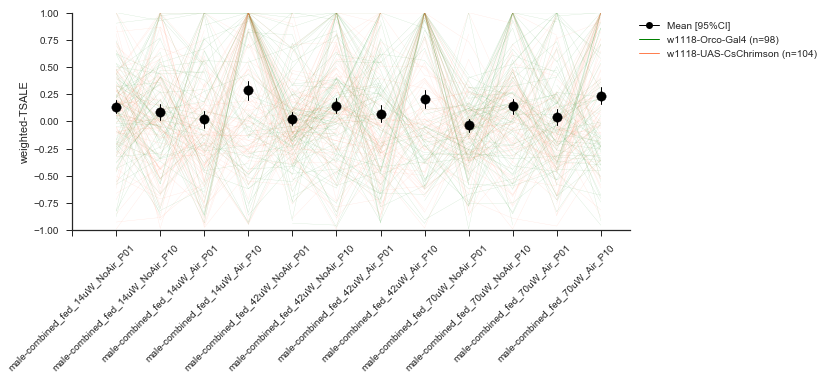

In [61]:
fig, s = sequentialPlot(Ctrl_across_conditions, color = False)
# fig, s = sequentialPlot(Exp_across_conditions, color = ['royalblue'])

fig

In [58]:
fname = 'Orco_Forward_ctrl'
fig.savefig("C:/Users/tumkayat/Desktop/Thesis/Figures/Chapter2/" + fname + ".pdf",dpi=1000,bbox_inches='tight')
s.to_csv("C:/Users/tumkayat/Desktop/Thesis/Figures/Chapter2/" + fname + ".csv")

In [62]:
s ## wtf is sample size so big






,CI_LB,CI_UB,Mean,Sample_size,Standart_dev,Steps
0,0.074254,0.198440,0.136347,202,0.450259,male-combined_fed_14uW_NoAir_P01
1,0.012908,0.154790,0.083849,202,0.514420,male-combined_fed_14uW_NoAir_P10
2,-0.058673,0.097584,0.019455,202,0.566536,male-combined_fed_14uW_Air_P01
3,0.195810,0.373134,0.284472,202,0.642919,male-combined_fed_14uW_Air_P10
4,-0.037549,0.083459,0.022955,202,0.438737,male-combined_fed_42uW_NoAir_P01
5,0.072725,0.215088,0.143906,202,0.516163,male-combined_fed_42uW_NoAir_P10
6,-0.010130,0.145982,0.067926,202,0.566011,male-combined_fed_42uW_Air_P01
7,0.120642,0.291212,0.205927,202,0.618431,male-combined_fed_42uW_Air_P10
8,-0.095004,0.025913,-0.034546,202,0.438404,male-combined_fed_70uW_NoAir_P01
9,0.064981,0.208569,0.136775,202,0.520605,male-combined_fed_70uW_NoAir_P10


## Contrast of the means across 12-steps

In [60]:
def ContrastofSequence(df_ctrl,df_exp):
    contrast_means = []
    contrast_CI_LB = []
    contrast_CI_UB = []
    
    for i in range(len(df1)):
        mean_ctrl = df_ctrl['Means'][i]
        mean_exp = df_exp['Means'][i]
        
        N_ctrl = df_ctrl['Sample_size'][i]
        N_exp = df_exp['Sample_size'][i]
        
        STD_ctrl = df_ctrl['Standart_dev'][i]
        STD_exp = df_exp['Standart_dev'][i]
        
        mean_diff = mean_exp - mean_ctrl
        
        moe = 1.96*sqrt(((STD_ctrl**2)/N_ctrl)+((STD_exp**2)/N_exp))
        CI_LB = mean_diff - moe
        CI_UB = mean_diff + moe
        
        contrast_means.append(mean_diff)
        contrast_CI_LB.append(CI_LB)
        contrast_CI_UB.append(CI_UB)
        
    ## import the libraries, set some parameters
    import itertools
    from matplotlib.lines import Line2D
    import scipy.stats

    style='ticks'
    context='notebook'
    font='Arial'

    sns.set(style=style,context =context,font=font)

    fig1 = plt.figure(figsize=(10,4))
    ax1 = fig1.add_subplot(111)
    
    ## plotting the mean dots , zorder specifies the layer order - i.e dots are in the front
    x1 = 1
    for i in range(len(contrast_means)):
        ax1.scatter(x1, contrast_means[i], s=90, c='k',zorder=10)
        ax1.plot([x1,x1], [contrast_CI_LB[i], contrast_CI_UB[i]], color='k', lw=1)
        x1 = x1 + 1

    ax1.set_ylim(-1,1)
    ax1.set_ylabel('weighted-TSALE')
    ax1.set_xticks(np.arange(0,len(condlist)*2+1))
    xlabel = []
    for c in condlist:
        xlabel.append(c + '_P01')
        xlabel.append(c + '_P10')
    ax1.set_xticklabels(xlabel,rotation=45)
    ax1.legend(custom_lines, legend_labels,bbox_to_anchor=(1, 1))

    sns.despine()

    return fig1

## Combine SVG images of all metrics in one

In [ ]:
def combineSVGImages(rootDirectory,epoch_to_combine):
    
    for ORN in ornList:
        rootDir = os.path.join(rootDirectory,ORN)

        ## Page 1
        Figure("59.4cm", "84.1cm", 
               ## LaxS images
            Panel(
                  SVG(rootDir + "/LaXS/" + epoch_to_combine + "/LaXS_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("A", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ),
            Panel(
                  SVG(rootDir + "/LaXS/" + epoch_to_combine + "/LaXS_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("B", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 0),
            Panel(
                  SVG(rootDir + "/LaXS/" + epoch_to_combine + "/LaXS_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("C", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 21),
            Panel(
                  SVG(rootDir + "/LaXS/" + epoch_to_combine + "/LaXS_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("D", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 21),

                ## TSALE images

            Panel(
                  SVG(rootDir + "/TSALE/" + epoch_to_combine + "/TSALE_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("E", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 42),
            Panel(
                  SVG(rootDir + "/TSALE/" + epoch_to_combine + "/TSALE_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("F", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 42),
            Panel(
                  SVG(rootDir + "/TSALE/" + epoch_to_combine + "/TSALE_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("G", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 63),
            Panel(
                  SVG(rootDir + "/TSALE/" + epoch_to_combine + "/TSALE_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("H", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 63)).save(rootDir+"/Metrics_Combined_p1" + epoch_to_combine + ".svg")


        ## Page 2

        Figure("59.4cm", "84.1cm", 
               ## weighted TSALE images
            Panel(
                  SVG(rootDir + "/weighted_TSALE/" + epoch_to_combine + "/weighted_TSALE_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("I", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ),
            Panel(
                  SVG(rootDir + "/weighted_TSALE/" + epoch_to_combine + "/weighted_TSALE_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("J", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 0),
            Panel(
                  SVG(rootDir + "/weighted_TSALE/" + epoch_to_combine + "/weighted_TSALE_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("K", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 21),
            Panel(
                  SVG(rootDir + "/weighted_TSALE/" + epoch_to_combine + "/weighted_TSALE_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("L", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 21),

                ## Light Attraction Index images

            Panel(
                  SVG(rootDir + "/LAI/" + epoch_to_combine + "/LAI_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("M", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 42),
            Panel(
                  SVG(rootDir + "/LAI/" + epoch_to_combine + "/LAI_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("N", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 42),
            Panel(
                  SVG(rootDir + "/LAI/" + epoch_to_combine + "/LAI_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("O", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 63),
            Panel(
                  SVG(rootDir + "/LAI/" + epoch_to_combine + "/LAI_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("P", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 63)).save(rootDir+"/Metrics_Combined_p2" + epoch_to_combine + ".svg")

        ## Page 3

        Figure("59.4cm", "84.1cm", 
               ## Reversal PI images
            Panel(
                  SVG(rootDir + "/RPI/" + epoch_to_combine + "/RPI_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("R", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ),
            Panel(
                  SVG(rootDir + "/RPI/" + epoch_to_combine + "/RPI_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("S", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 0),
            Panel(
                  SVG(rootDir + "/RPI/" + epoch_to_combine + "/RPI_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("T", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 21),
            Panel(
                  SVG(rootDir + "/RPI/" + epoch_to_combine + "/RPI_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("U", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 21),

                ## DeltaPercentTimeSpent images

            Panel(
                  SVG(rootDir + "/DeltaPercentTimeSpent/" + epoch_to_combine + "/DeltaPercentTimeSpent_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("V", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 42),
            Panel(
                  SVG(rootDir + "/DeltaPercentTimeSpent/" + epoch_to_combine + "/DeltaPercentTimeSpent_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("W", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 42),
            Panel(
                  SVG(rootDir + "/DeltaPercentTimeSpent/" + epoch_to_combine + "/DeltaPercentTimeSpent_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("X", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 63),
            Panel(
                  SVG(rootDir + "/DeltaPercentTimeSpent/" + epoch_to_combine + "/DeltaPercentTimeSpent_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("Y", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 63)).save(rootDir+"/Metrics_Combined_p3" + epoch_to_combine + ".svg")

        ## Page 4

        Figure("59.4cm", "84.1cm", 
               ## Log2SpeedRatio images
            Panel(
                  SVG(rootDir + "/Log2SpeedRatio/" + epoch_to_combine + "/Log2SpeedRatio_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("Z", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ),
            Panel(
                  SVG(rootDir + "/Log2SpeedRatio/" + epoch_to_combine + "/Log2SpeedRatio_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("Ai", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 0),
            Panel(
                  SVG(rootDir + "/Log2SpeedRatio/" + epoch_to_combine + "/Log2SpeedRatio_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("Bi", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 21),
            Panel(
                  SVG(rootDir + "/Log2SpeedRatio/" + epoch_to_combine + "/Log2SpeedRatio_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("Ci", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 21),

                ## SpeedCrossingInside images

            Panel(
                  SVG(rootDir + "/SpeedCrossingInside/" + epoch_to_combine + "/SpeedCrossingInside_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("Di", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 42),
            Panel(
                  SVG(rootDir + "/SpeedCrossingInside/" + epoch_to_combine + "/SpeedCrossingInside_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("Ei", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 42),
            Panel(
                  SVG(rootDir + "/SpeedCrossingInside/" + epoch_to_combine + "/SpeedCrossingInside_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("Fi", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 63),
            Panel(
                  SVG(rootDir + "/SpeedCrossingInside/" + epoch_to_combine + "/SpeedCrossingInside_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("Gi", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 63)).save(rootDir+"/Metrics_Combined_p4" + epoch_to_combine + ".svg")

        ## Page 5

        Figure("59.4cm", "84.1cm", 
               ## SpeedCrossingOutside images
            Panel(
                  SVG(rootDir + "/SpeedCrossingOutside/" + epoch_to_combine + "/SpeedCrossingOutside_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("Hi", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ),
            Panel(
                  SVG(rootDir + "/SpeedCrossingOutside/" + epoch_to_combine + "/SpeedCrossingOutside_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("Ii", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 0),
            Panel(
                  SVG(rootDir + "/SpeedCrossingOutside/" + epoch_to_combine + "/SpeedCrossingOutside_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("Ji", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 21),
            Panel(
                  SVG(rootDir + "/SpeedCrossingOutside/" + epoch_to_combine + "/SpeedCrossingOutside_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("Ki", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 21),

                ## NoBC images

            Panel(
                  SVG(rootDir + "/NoBC/" + epoch_to_combine + "/NoBC_CombinedControls_" + epoch_to_combine + "_male_fed_NoAir.svg").scale(0.025),
                  Text("Li", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 42),
            Panel(
                  SVG(rootDir + "/NoBC/" + epoch_to_combine + "/NoBC_CombinedControls_" + epoch_to_combine + "_male_fed_Air.svg").scale(0.025),
                  Text("Mi", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Fed | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 42),
            Panel(
                  SVG(rootDir + "/NoBC/" + epoch_to_combine + "/NoBC_CombinedControls_" + epoch_to_combine + "_male_starved_NoAir.svg").scale(0.025),
                  Text("Ni", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | No Air", 13, 1, size=0.5, weight='bold')
                 ).move(0, 63),
            Panel(
                  SVG(rootDir + "/NoBC/" + epoch_to_combine + "/NoBC_CombinedControls_" + epoch_to_combine + "_male_starved_Air.svg").scale(0.025),
                  Text("Oi", 3, 1, size=1, weight='bold'),
                  Text(ORN + " | Starved | Air", 13, 1, size=0.5, weight='bold')
                 ).move(26.5, 63)).save(rootDir+"/Metrics_Combined_p5" + epoch_to_combine + ".svg")
    return None
    
    
            

In [ ]:
rootDir = 'C:/Users/tumkayat/Desktop/ORScreening/WALiSAR_all_ORNs/'
    
combineSVGImages(rootDir,epoch_to_combine = 'P10' )